# **Unreported Curtailment Analysis**



## Data loading and imports

### Imports

In [9]:
from google.colab import drive
drive.mount('/content/drive')

!pip install  pickle5

import pickle5 as pickle
import xlwt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from scipy import stats
from datetime import datetime, timedelta
from IPython.display import display, clear_output, HTML
from sklearn.feature_selection import mutual_info_classif
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Definitions (paths, parameters...)

In [10]:
root = 'drive/MyDrive/gdt data/'
eventfile = root+'2021_GDT_Warning_Events.pkl'
curtailmentfile = root+'2021_GDT_curtailment.pkl'
setpointfile = root+'2021_GDT_setpoint.pkl'
windfile = root+'2021_GDT_wind.pkl'
alarmfile = root+'2021_GDT_alarms.pkl'

# Thomas' files for validation
Val_GDT004 = root+'GDT004_2020_now'
Val_GDT005 = root+'GDT005_2020_now'
Val_GDT022 = root+'GDT022_2020_now'
Val_GDT024 = root+'GDT024_2020_now'
Val_GDT025 = root+'GDT025_2020_now'

### loading data

In [11]:
with open(setpointfile, "rb") as fh:
  SCADA_setpoint = pickle.load(fh)

with open(eventfile, "rb") as fh:
  turbine_events = pickle.load(fh)

with open(curtailmentfile, "rb") as fh:
  curtailment_reports = pickle.load(fh)

with open(windfile, "rb") as fh:
  SCADA_wind = pickle.load(fh)

with open(alarmfile, "rb") as fh:
  turbine_alarms = pickle.load(fh)

In [12]:
with open(Val_GDT004, "rb") as fh:
  Val_GDT004 = pickle.load(fh)
with open(Val_GDT005, "rb") as fh:
  Val_GDT005 = pickle.load(fh)
with open(Val_GDT022, "rb") as fh:
  Val_GDT022 = pickle.load(fh)
with open(Val_GDT024, "rb") as fh:
  Val_GDT024 = pickle.load(fh)
with open(Val_GDT025, "rb") as fh:
  Val_GDT025 = pickle.load(fh)

In [13]:
if 'Querydate' in curtailment_reports:
  curtailment_reports = curtailment_reports.drop(['Querydate', 'From_Local', 'To_Local', 'Duration', 'Comment', 'Id', 'LostProduction', 'Park', 'Production', 'ProductionLostTotal', 'ProductionTotal'], axis = 1)
if 'From_UTC' in curtailment_reports:
  # Rounding to closest 10 mins is a possible source of model bias
  curtailment_reports['From'] = curtailment_reports['From_UTC'].dt.floor('10min')
  curtailment_reports['To'] = curtailment_reports['To_UTC'].dt.round('10min')
  curtailment_reports = curtailment_reports.drop(['From_UTC', 'To_UTC'], axis=1)

In [14]:
turbine_alarms['ErrorType'] = 'Alarm'
if 'Unit' in turbine_alarms:
  turbine_alarms['Turbine'] = turbine_alarms['Unit']
  turbine_alarms = turbine_alarms.drop(['Unit'], axis=1)
"""
if 'From_Floor' in turbine_alarms:
  turbine_alarms['From'] = turbine_alarms['From_Floor']
  turbine_alarms['To'] = turbine_alarms['To_Floor']
  turbine_alarms = turbine_alarms.drop(['From_Floor', 'To_Floor'], axis=1)
"""
if 'From_UTC' in turbine_alarms:
  turbine_alarms['From'] = turbine_alarms['From_UTC'].dt.floor('10min') #possible cause for missed correlations if curtailment triggers shortly after event
  turbine_alarms['To'] = turbine_alarms['To_UTC'].dt.round('10min') # round should alleviate the above-stated problem
  turbine_alarms = turbine_alarms.drop(['From_UTC', 'To_UTC'], axis=1)

if 'AlarmTxt' in turbine_alarms:
  turbine_alarms['Text'] = turbine_alarms['AlarmTxt']
  turbine_alarms = turbine_alarms.drop(['AlarmTxt'], axis=1)

if 'AlarmCode' in turbine_alarms:
  turbine_alarms['ErrorCode'] = turbine_alarms['AlarmCode']
  turbine_alarms = turbine_alarms.drop(['AlarmCode'], axis=1)


In [15]:
rename = [col for col in SCADA_setpoint.columns if 'WTUR11_WSpt_val_max' in col]

print('turbine events length:', len(turbine_events))
print('turbine alarms length:', len(turbine_alarms))


if len(rename) > 0:
    df['Tag'] = 'WTUR11_WSpt_val'
    df['Value'] = df['WTUR11_WSpt_val_max']
    df['Timestamp'] = df['StartTime']

if 'Unit' in turbine_events:
  turbine_events['Turbine'] = turbine_events['Unit']
  turbine_events = turbine_events.drop(['Unit'], axis=1)
if 'From_Floor' in turbine_events:
  turbine_events['From'] = turbine_events['From_Floor']
  turbine_events['To'] = turbine_events['To_Floor']
  turbine_events = turbine_events.drop(['From_Floor', 'To_Floor'], axis=1)
if 'From_UTC' in turbine_events:
  turbine_events['From'] = turbine_events['From_UTC'].dt.floor('10min') #possible cause for missed correlations if curtailment triggers shortly after event
  turbine_events['To'] = turbine_events['To_UTC'].dt.round('10min') # round should alleviate the above-stated problem
  turbine_events = turbine_events.drop(['From_UTC', 'To_UTC'], axis=1)
if 'ID' in turbine_events:
  turbine_events = turbine_events.drop(['ID', 'Source', 'CustomText', 'Wallclock_UTC', 'CommFailure', 'MayTrigger', 'RemoteID', 'Created_UTC', 'ErrorListID', 'RowLastUpdated'], axis=1)
turbine_events =  pd.concat([turbine_events ,turbine_alarms], ignore_index=True) #merge alarms and events into one dataframe

turbine_events['Duration'] = turbine_events.To - turbine_events.From

print('length after merging:', len(turbine_events))

turbine events length: 87609
turbine alarms length: 3415
length after merging: 91024


In [16]:
long_events = (turbine_events['To'] - turbine_events['From']  < pd.Timedelta(value=31, unit='days'))
print('Number of events that exceed one month: ', len(long_events[long_events == False]))
turbine_events = turbine_events[long_events]
print('Remaining length: ', len(turbine_events))

Number of events that exceed one month:  293
Remaining length:  90731


Removing events that are longer than one month.

## Model functions: information gathering and rule-based alaysis

### Utility

In [17]:
def navigator(*argv, function=None):
    """
    Small CLI-style function that helps to sequentially execute commands 
    on user input.
    type "y" to continue and "n" to exit

    Args:
        function to be executed, takes an integer as parameter

    Returns:
        Nothing
    """

    counter = 0
    while(True):
      print('index ', counter, ' ...continue?')
      val = input()
      if val == 'n':
        break
      else:
        function(argv, i=counter)
      counter += 1

def within_margin(target_value, comparison_value, maxval: int, difference_ratio=0.02):
    """
    Evaluate whether the target value falls into a interval around the
    comparison value. The interval is defined as percentage of the maximum value
    for the dataset. This is used to determine oscillating values pertaining to
    the same curtailment event (controller curtailment) and gradual change
    as opposed to constant values (technician curtailment). 

    Args:
        target_value: the value or vector of values being compared/checked
        comparison value: the value or vector of values 
        at the center of the interval
        maxval: the highest value in the dataset
        difference_ratio: the ratio that defines the interval

    Returns:
        True if target_value is close enough to comparison_value. False othewise.
    """

    return np.abs(target_value-comparison_value) < (maxval * difference_ratio )

def progress(value: float, max=100):
    """Display progress bar for execution

    Args:
        value: progress value
        max: maximum value of progress (default 100)

    Returns:
        Html progress bar

    """
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

def during(start1: pd.Timestamp, end1: pd.Timestamp, end2: pd.Timestamp):
    """Check whether event 1 is happening during event 2 
    (check for positive overlap of the two events)

    Args:
        start1: Timestamp indicating the start of event 1
        end1: Timestamp indicating the end of event 1
        end2: Timestamp indicating the end of event 2

    Returns:
        True if event 2 happens (partly) during event 1, False otherwise

    """

    latest = max(start1, end2)
    earliest = min(end1, end2)
    delta = pd.Timedelta((earliest - latest)).total_seconds()
    
    if delta < 0:
        return False
    return True

### Reflections and statistics about turbine data

In [18]:
len(SCADA_setpoint['Turbine'].unique())

80

Number of turbines in park.

In [19]:
max_val = SCADA_setpoint['Value'].max()
max_val

3600.0

rated power of the Siemens turbines deployed at GDT is 3600 kW. Cut-in wind speed : 3.5 m/s, Rated-end: 24 m/s, Cut-out: 25 m/s (High wind ride through suspected, but often not reported)

In [20]:
avg_events = turbine_events.groupby("Turbine", axis=0)["ErrorCode"].count().mean()
print(avg_events)

1134.1375


Average number of events (alarms included) per Turbine.

In [21]:
avg_unique_events = turbine_events.groupby("Turbine", axis=0)["ErrorCode"].nunique().mean()
avg_unique_events

65.425

Average number of unique event codes per Turbine.

In [22]:
print(len(curtailment_reports), ' reported curtailments', ' between ', curtailment_reports.From.min(), ' and ', curtailment_reports['To'].max())

39  reported curtailments  between  2021-01-03 12:20:00  and  2021-05-19 18:10:00


In [23]:
avg_len_data = SCADA_wind.groupby("Turbine", axis=0)['Value'].count().mean()
print("average number of data points per turbine: ", avg_len_data )
avg_number_of_data_points_below_cut_in = SCADA_wind[SCADA_wind['Value'] <= 3.5].groupby("Turbine", axis=0)['Value'].count().mean()
print("average number of data points below cut in power per turbine: ", round(avg_number_of_data_points_below_cut_in,2))
print("percentage of data points below cut in: ", round(avg_number_of_data_points_below_cut_in/avg_len_data*100, 4), "%")
avg_number_of_data_points_above_rated = SCADA_wind[SCADA_wind['Value'] >= 24].groupby("Turbine", axis=0)['Value'].count().mean()
print("average number of data points above rated power per turbine: ", round(avg_number_of_data_points_above_rated, 4))
print("percentage of data points in possible HWRT zone: ", round(avg_number_of_data_points_above_rated/avg_len_data*100, 4), "%")

average number of data points per turbine:  16672.1625
average number of data points below cut in power per turbine:  1794.97
percentage of data points below cut in:  10.7663 %
average number of data points above rated power per turbine:  36.1538
percentage of data points in possible HWRT zone:  0.2169 %


Even though the model has a rule to flag potential instances of High Wind Ride Through, this has a minor impact, as the occurences of very high windspeed are merely **0.2%** of the data

In [24]:
setpoint = SCADA_setpoint.pivot_table(index=['Timestamp'], columns=['Turbine'])

highest_number_of_nan = setpoint.isna().sum().max()
average_number_of_nan = setpoint.isna().sum().mean()
avg_num_of_datapoint = setpoint.count().mean()
print('highest number of nans after regrouping into timeseries: ', highest_number_of_nan)
print('average number of nans after regrouping into timeseries: ', average_number_of_nan)
print('average number of datapoints in total: ', avg_num_of_datapoint)
print('As percentages. avg: ', round((average_number_of_nan/avg_num_of_datapoint)*100, 2), '%. max: ', round((highest_number_of_nan/avg_num_of_datapoint)*100, 2), '%')

setpoint = setpoint.stack().swaplevel(i='Turbine', j='Timestamp')
print('Length of turbine dataframe after stacking: ', len(setpoint.xs('GDT058', level='Turbine')), 'compared to max length: ', SCADA_setpoint.groupby("Turbine", axis=0)['Value'].count().max())


highest number of nans after regrouping into timeseries:  2841
average number of nans after regrouping into timeseries:  417.3875
average number of datapoints in total:  16673.6125
As percentages. avg:  2.5 %. max:  17.04 %
Length of turbine dataframe after stacking:  14250 compared to max length:  17078


Regrouping SCADA tags into a time series represents a big challenge: how to deal with NaN values?

In theory, the **average number of NaN's is accetably low -  2.5%** of values are NaN. However, most NaN values are **stacked and concentrated** in data of Turbines with lots of missing data. In primis, **17% of the data for Turbine 58 are NaN values**.

Fortunately, this is not a problem for Turbine-specific operations, as the NaN rows are removed when extracting a cross-section from the pivot table.

For aggregated park operations, however, this will be a major issue.  Currently, NaN values are **backfilled** with the next valid value. This approach might have to be reevaluated. 

TODO: find the spot with high wind outliers again and document it.

In [25]:
turbine_events['Duration'] = turbine_events.To - turbine_events.From
turbine_events[turbine_events.ErrorCode == 5112].sort_values(by=['Duration'], ascending=False).head(10)

,ErrorCode,Text,ErrorType,Turbine,From,To,Duration
76643,5112,Gridvolt.<lower limit3,Alarm,GDT018,2021-01-07 15:10:00,2021-01-14 15:00:00,6 days 23:50:00
76990,5112,Gridvolt.<lower limit3,Alarm,GDT016,2021-01-09 16:00:00,2021-01-14 13:30:00,4 days 21:30:00
81523,5112,Gridvolt.<lower limit3,Alarm,GDT015,2021-01-04 03:40:00,2021-01-08 13:50:00,4 days 10:10:00
5501,5112,Gridvolt.<lower limit3,Alarm,GDT019,2021-04-23 06:30:00,2021-04-26 10:00:00,3 days 03:30:00
5771,5112,Gridvolt.<lower limit3,Alarm,GDT033,2021-04-22 17:40:00,2021-04-25 13:30:00,2 days 19:50:00
79689,5112,Gridvolt.<lower limit3,Alarm,GDT017,2021-01-07 12:20:00,2021-01-09 16:10:00,2 days 03:50:00
15228,5112,Gridvolt.<lower limit3,Alarm,GDT017,2021-04-13 13:10:00,2021-04-15 12:40:00,1 days 23:30:00
14191,5112,Gridvolt.<lower limit3,Alarm,GDT017,2021-04-15 12:40:00,2021-04-17 10:00:00,1 days 21:20:00
79793,5112,Gridvolt.<lower limit3,Alarm,GDT016,2021-01-07 20:40:00,2021-01-09 14:40:00,1 days 18:00:00
76892,5112,Gridvolt.<lower limit3,Alarm,GDT037,2021-01-13 00:20:00,2021-01-14 13:50:00,1 days 13:30:00


Event **5112** has been investigated in an ad-hoc request by the Analytics team and has shown some **connection to curtailment**. Unfortunately, the longest duration event (almost 7 days) on turbine GDT018 has **no setpoint data at all for that period**. **Production is also zero** for that period.

In [26]:
SCADA_setpoint[SCADA_setpoint.Turbine == 'GDT015'].sort_values(by='Timestamp').set_index(['Timestamp']).loc["2021-01-04 03:30:00":"2021-01-08 14:00:00"]

,Value,Tag,Turbine
Timestamp,,,
2021-01-04 03:30:00,1573.0,WTUR11_WSpt_val,GDT015
2021-01-04 03:40:00,1665.0,WTUR11_WSpt_val,GDT015
2021-01-04 03:50:00,0.0,WTUR11_WSpt_val,GDT015
2021-01-04 04:00:00,0.0,WTUR11_WSpt_val,GDT015
2021-01-04 04:10:00,0.0,WTUR11_WSpt_val,GDT015
2021-01-04 04:20:00,0.0,WTUR11_WSpt_val,GDT015
2021-01-04 04:30:00,0.0,WTUR11_WSpt_val,GDT015
2021-01-08 13:40:00,3600.0,WTUR11_WSpt_val,GDT015
2021-01-08 13:50:00,124.0,WTUR11_WSpt_val,GDT015


As shown here for turbine GDT015, The timestamps where event 5112 is active have no discernable pattern: the setpoint is 0 at times and at full rated power at others.

### Turbine specific functions

#### Event-related


In [27]:
def expand_dummy_event_columns(turbine_curtailments: pd.DataFrame, turbine_events: pd.DataFrame, missing_as_na=False):
  """
  Add a dummy column for each event code to turbine curtailment containing the
  overlap ratio. 0 for non-ovelapping.

  Args:
      turbine_curtailments:  DataFrame containing detected curtailment events
      per turbine.
      turbine_events: DataFrame containing events and alarms for one turbine.
      missing_as_na: if True, exapnded dataframe will be filled with na's, 
      otherwise with zeroes

  Returns:
      Adds a column for each event code and returns modified dataframe
  """

  filler = np.nan if missing_as_na else 0.
  event_codes = turbine_events.ErrorCode.unique()
  def create_list(event_codes):
    for code in event_codes:
      yield (str(code) + '_Curtailment_Coverage')
      yield (str(code) + '_Coverage_Duration') 
      yield (str(code) + '_Coverage_Ratio')



  if isinstance(turbine_curtailments, list):   
    for curtailment in range(len(turbine_curtailments)):
      # Need to generate list in every loop iteration, otherwise it "runs out
      # of objects"
      col_list = create_list(event_codes) 

      extra_cols = pd.DataFrame(filler, index=turbine_curtailments[curtailment].index, columns=list(col_list))

      turbine_curtailments[curtailment] = pd.concat([turbine_curtailments[curtailment], extra_cols], axis=1)

  elif isinstance(turbine_curtailments, pd.DataFrame):

      col_list = create_list(event_codes)

      extra_cols = pd.DataFrame(filler, index=turbine_curtailments.index, columns=list(col_list))

      turbine_curtailments = pd.concat([turbine_curtailments, extra_cols], axis=1)
  else:
    print("Error: object to expand is neither a list of curtailments nor a single turbine curtailment dataframe!")

  return turbine_curtailments


def efficient_event_overlap_calculation(turbine_curtailments: pd.DataFrame, single_turbine_events: pd.DataFrame):
  # TODO: investigate and fix possible bug when multiple events with the same 
  # code overlap a zero-duration curtailment window.

  """
  Evaluate overlap ratios between events and detected curtailment. 0 means no
  overlap.

  Same caveats as with efficient_curtailment_overlap_calculation apply.

  Args:
      turbine_curtailments:  DataFrame containing detected curtailment events
      per turbine.
      turbine_events: DataFrame containing events and alarms for one turbine.

  Returns:
      Void. Adds three columns for each event code containing the ratio of overlap
      of the event by curtailment, the ratio of overlap of the curtailment by the
      event and the duration of this overlap.

      NB: In previous versions of this project both the ratio of overlap for the
      event by the curtailment and for the curtailment by the event were
      determined. There is a case to be made that the latter might be an 
      interesting metric too: currently, a very short event that happens during 
      curtailment will have a high overlap ratio, but explain very little about 
      the curtailment event.

      Deprecated: 
        --Adds two columns: list of overlapping events and list of ratios.--
        Now replaced by dummy columns
  """

  if turbine_curtailments.columns.str.contains(pat = 'Coverage').any():

    for detected_turbine_curtailment in turbine_curtailments.iloc:
      overlappers = single_turbine_events[(~(single_turbine_events.index > detected_turbine_curtailment.End) & ~(single_turbine_events.To < detected_turbine_curtailment.name))]
      for event in overlappers.iloc:
        code = str(event['ErrorCode'])
        coverage = pd.Timedelta(min(detected_turbine_curtailment.End, event.To)-max(detected_turbine_curtailment.name, event.name)).total_seconds()
        curtailment_duration = pd.Timedelta(detected_turbine_curtailment.End-detected_turbine_curtailment.name).total_seconds()
        if curtailment_duration == 0:
          turbine_curtailments.at[detected_turbine_curtailment.name, code + '_Curtailment_Coverage'] = 1.
        else:
          turbine_curtailments.at[detected_turbine_curtailment.name, code + '_Curtailment_Coverage'] = (coverage/curtailment_duration)

        turbine_curtailments.at[detected_turbine_curtailment.name, code + '_Coverage_Duration'] += coverage

        event_duration = pd.Timedelta(event.To-event.name).total_seconds()
        if event_duration == 0:
          turbine_curtailments.at[detected_turbine_curtailment.name, code + '_Coverage_Ratio'] = 1
        else:
          turbine_curtailments.at[detected_turbine_curtailment.name, code + '_Coverage_Ratio'] = coverage/event_duration
        
        """
        if code == '5112' and event_duration != 0 and curtailment_duration != 0:
          display(detected_turbine_curtailment)
          display(overlappers)
          display(overlappers[overlappers.ErrorCode == 5112])
          print("coverage ", coverage)
          print("curtailment cov ", coverage/curtailment_duration)
          print("coverage ratio> ", coverage/event_duration)
          display("Curtailment coverage in output dataframe: ", turbine_curtailments.at[detected_turbine_curtailment.name, code + '_Curtailment_Coverage'])
        """

  else:
    print("please expand the columns first")


def delete_long_events(turbine_events: pd.DataFrame, turbine_curtailments: pd.DataFrame):
  """
  Deletes all events in turbine_events that are longer than the longest curtailment

  Args:
      turbine_curtailments:  DataFrame containing detected curtailment events
      per turbine.
      turbine_events: DataFrame containing events and alarms for one turbine.

  Returns:
      trimmed DataFrame.
  """

  names = SCADA_setpoint["Turbine"].unique()
  names = np.sort(names)
  len_before = len(turbine_events)
  for i in range(1):
    a[i]['Duration'] = a[i].End - a[i].index
    turbine_events = turbine_events[((turbine_events.To - turbine_events.From < a[i]['Duration'].max()) | (turbine_events.Turbine == names[i]))] 
  print('Deleted ', len_before-len(turbine_events), ' long duration events from turbine event DataFrame')
  return turbine_events

#### Curtailment-related


In [28]:
def high_wind_ride_through(current_turbine: pd.DataFrame, current_wind: pd.DataFrame) :
    """
    Calculate whether for a certain timestamp high wind ride through is likely

    Args:
        current_turbine: DataFrame containing flagged data of one turbine
        current_wind: DataFrame containing SCADA ambient wind data for one 
        turbine

    Returns:
        DataFrame with column with wind flags
    """

    current_wind = current_wind.set_index(['Timestamp'])
    current_wind = current_wind.sort_index()

    current_turbine['HWRT'] = (current_wind['Value'] > 24)


    current_turbine = current_turbine.fillna(value={'HWRT': False})    
    return current_turbine

def technician_curtailment(current_turbine: pd.DataFrame):
  """
  Evaluate whether a curtailment is technician curtailment

  Args:
      current_turbine: DataFrame containing flagged data of one turbine
      current_wind: DataFrame containing SCADA ambient wind data for one 
      turbine

  Returns:
      DataFrame with column with wind flags
  """

  previous_val = current_turbine['Value'].shift()
  next_val = current_turbine['Value'].shift(-1)
  after_next_val = current_turbine['Value'].shift(-1).shift(-1)

  # Technician curtailment is active if the turbine is curtailed and the next two
  # values are the exactly the same, or the previous one is exactly the same, as
  # the current one
  current_turbine['isTechnicianCurtailment'] = \
    current_turbine['isCurtailed'] & (((next_val == current_turbine['Value']) & \
    (after_next_val == current_turbine['Value'])) | \
    (previous_val == current_turbine['Value']))

  return current_turbine


def efficient_curtailment_overlap_calculation(turbine_curtailments: pd.DataFrame, curtailment_reports: pd.DataFrame, timeseries=False):
  """
  Compare discovered curtailments with curtailment reports and add a column
  containing a flag for whether there is overlap.

  Overlap is calculated optimistically in favor of reported curtailments
  if working with floored timestamps (as is the case with the default data 
  loading for this project). For example, a detected curtailment might end at
  'xx-xx-xxxx 15-43-000' and a curtailment report might start at 
  'xx-xx-xxxx 15-47-000'; subsequently, both are floored to the closest 10-minute
  interval at 'xx-xx-xxxx 15-40-000' and counted as overlapping.

  Args:
      turbine_curtailments:  DataFrame containing detected curtailment events
      per turbine
      curtailment_reports: DataFrame containing curtailment reports from
      fact.CurtailmentNew
      timeseries: Boolean. If True, will set end time to start time for time series.

  Returns:
      Void. Adds boolean column 'Reported' to turbine_curtailments.
  """
  
  curtailment_reports = curtailment_reports.sort_values(by=['From'])
  curtailment_reports = curtailment_reports.set_index('From')
  

  iterator1 = turbine_curtailments.iterrows()
  iterator2 = curtailment_reports.iterrows()
  index1, row1 = next(iterator1)
  index2, row2 = next(iterator2)
  turbine_curtailments['Reported'] = False

  # Only one iteration
  while True:
    try:
      if timeseries:
        range1 = pd.Interval(left=row1.name, right=row1.name)
      else:
        range1 = pd.Interval(left=row1.name, right=row1.End)
      range2 = pd.Interval(left=row2.name, right=row2.To)
      if range2.right < range1.left:
        # no overlap. range2 before r1. advance iterator2
        index2, row2 = next(iterator2)
      elif range1.right < range2.left:
        # no overlap. range1 before r2. advance iterator1
        index1, row1 = next(iterator1)
      else:
        # overlap. overlap(row1, row2) must > 0 
        turbine_curtailments.loc[index1, 'Reported'] = True
        # determine whether to advance iterator1 or it2
        if range1.right < range2.right:
            # advance iterator1
            index1, row1 = next(iterator1)
        else:
          # advance iterator2
          index2, row2 = next(iterator2)
    except StopIteration:
      break


def extract_curtailment_windows(SCADA_setpoint: pd.DataFrame, 
                                difference_ratio=0.1, 
                                count_zero_as_curtailment=False,
                                missing_as_rated=False, 
                                additional_flags=False,
                                fill_missing_data=False,
                                SCADA_wind = None, 
                                curtailment_reports = None, 
                                turbine_events=None):
  """
  Extract curtailment windows from SCADA per turbine.

  Args:
      SCADA_setpoint: DataFrame containing the setpoint signal

      difference_ratio: ratio to determine maximum deviation after which
      a setpoint change is considered new curtailment

      additional_flags: if True, additional information such as high wind 
      ride through will be added, thus save iterations

      count_zero_as_curtailment: if True, setpoint values of 0 and 1 will be
      counted as curtailment

      fill_missing_data: if True, missing setpoint values are filled with 0 for
      all timestamps present for at least one turbine. Otherwise remaining
      timestamps are treated as non-existing in single-turbine operations.

      SCADA_Wind: ambient wind scada data, only needed if additional_flags is 
      True

      curtailment_reports: Park curtailment reports, only necessary if 
      additional_flags is set

      turbine_events: turbine event data for all turbines, only necessary if 
      additional_flags is set

      missing_as_rated: if True, missing setpoint values will be treated as
      normal operations, i.e. they will be set to rated power

  Returns:
      list of dataframes with curtailment events per turbine and list of
      dataframes of flagged timeseries per turbine
  """

  setpoint = SCADA_setpoint
  max_val = setpoint['Value'].max()
  
  # If missing data has to be filled
  if fill_missing_data: 
    
    # Default: fill with zeros
    if missing_as_rated: 
      setpoint = setpoint.pivot_table(index=['Timestamp'], columns=['Turbine'], fill_value=max_val)
    
    # Optionally: fill with rated power: business as usual
    else: 
      setpoint = setpoint.pivot_table(index=['Timestamp'], columns=['Turbine'], fill_value=0)
  
  # Otherwise: don't fill missing data
  else:
    setpoint = setpoint.pivot_table(index=['Timestamp'], columns=['Turbine'])
  setpoint = setpoint.stack().swaplevel(i='Turbine', j='Timestamp')


  names = SCADA_setpoint["Turbine"].unique()
  names = np.sort(names)
  curtailment_widows=[]
  turbine_with_curtailments=[]

  progresscnt = 0
  progressbar = display(progress(0, len(names)), display_id=True)

  for name in names:

    progresscnt += 1

    turbine_data = setpoint.xs(name, level='Turbine').copy()

    previous_val = turbine_data['Value'].shift()
    current_val = turbine_data['Value']

    # isChanged is true when the current value is outside a (user-specified) range 
    # around the previous value. It is also true if a value close to 0|1
    # goes to 0|1 and if a low value comes right after a 0|1 
    # (unless count_zero_as_curtailment is set)
    turbine_data['isChanged'] = \
      ~within_margin(previous_val, current_val, max_val, difference_ratio=difference_ratio) | \
      ((current_val == max_val) & (previous_val != max_val)) | \
      ((current_val != max_val) & (previous_val == max_val)) | \
      ((((current_val-2 < 0) & (previous_val -2 >= 0)) | \
      ((previous_val-2 < 0) & (current_val -2 >= 0))) & ~count_zero_as_curtailment)

    # isCurtailed is True whenever a turbine's setpoint is not at rated power and
    # not at 0 or 1 (unless count_zero_as_curtailment is set)
    turbine_data['isCurtailed'] = (turbine_data['Value'] != max_val) & \
      (((turbine_data['Value'] != 0)  & (turbine_data['Value']  != 1)) \
      | count_zero_as_curtailment)

    # StartCurtailment is whenever the setpoint changes and 
    #the turbine is curtailed
    turbine_data['StartCurtailment'] = turbine_data['isCurtailed'] & \
      turbine_data['isChanged']

    # A curtailment window ends when the next value is different and the current
    # value is not curtailed. If the data ends with curtailment, an End is added 
    # too
    turbine_data['EndCurtailment'] = \
      turbine_data['isCurtailed'] & turbine_data['isChanged'].shift(-1) | \
      turbine_data['isCurtailed'] & turbine_data['isChanged'].shift(-1).isna()

    turbine_curtailments = pd.DataFrame()
    # Get first timestamp of active curtailment event
    turbine_curtailments['Start'] = turbine_data[turbine_data['StartCurtailment']==True].index

    # Get last timestamp of active curtailment event
    turbine_curtailments['End'] = turbine_data[turbine_data['EndCurtailment']==True].index

    turbine_curtailments = turbine_curtailments.set_index(['Start'])

    if additional_flags:
      # Add HWRT to turbine data
      turbine_data = high_wind_ride_through(turbine_data, \
        SCADA_wind[SCADA_wind['Turbine'] == name])
      
      # Add HWRT to curtailment windows, if the start of the curtailment has 
      # high wind (possibly problematic)
      turbine_curtailments['HWRT'] = \
        turbine_data.loc[turbine_curtailments.index]['HWRT'].values

      # Add technician curtailment flags to turbine data and curtailment data
      turbine_data = technician_curtailment(turbine_data)

      # A curtailment window is flagged as technician curtailment if the first
      # instance of curtailment within its respective turbine's time series data 
      # is flagged as technician curtailment (possibly problematic)
      turbine_curtailments['isTechnicianCurtailment'] = \
      turbine_data.loc[turbine_curtailments.index]['isTechnicianCurtailment']

      # Add a flag for reported curtailment
      efficient_curtailment_overlap_calculation(turbine_data, curtailment_reports, timeseries=True)
      efficient_curtailment_overlap_calculation(turbine_curtailments, curtailment_reports, timeseries=False)

      # Expand columns (preparation for next step)
      turbine_curtailments = expand_dummy_event_columns(turbine_curtailments, turbine_events)

      # Expand turbine curtailment to include event information
      single_turbine_events = turbine_events[turbine_events.Turbine == name].sort_values(by=['From'])
      single_turbine_events = single_turbine_events.set_index('From')
      efficient_event_overlap_calculation(turbine_curtailments, single_turbine_events)

    # Add turbine curtailments to the list of curtailment windows per turbine
    # The turbines in the list are sorted lexicographically, so GDT001 is the
    # first
    curtailment_widows.append(turbine_curtailments)
    turbine_with_curtailments.append(turbine_data)

    # update progress bar
    progressbar.update(progress(progresscnt, len(names)))
  return curtailment_widows, turbine_with_curtailments



efficient_ovelap_calculation inspired by bechmarking answers in [this stackoverflow post](https://https://stackoverflow.com/questions/50031780/efficiently-find-overlap-of-date-time-ranges-from-2-dataframes)



It has been brought to my attention that the analytics package has a events to time series function. Unfortunately, there events are merged, which might lead to major discrepancies between expected results of the statistics part. Additionally, overlap metrics are harder to compute with a time series as opposed to a dataframe with start and end times.

Determining **event overlap** with curtailment is a tricky task. There are several challenges:


1.   What metric to use? Boolean overlap is easier to compute with respect to both code complexity and runtime efficiency, as it can make use of optimized library methods such as Interval.overlaps, but it also discards a lot of information. Knowing **how much of an event's duration is covered** by curtailment is key to determine its impact and possibly establish causality.
2.  The efficient overlap calculation running in O(n) time, where n is the size of the event DataFrame **assumes non-overlapping events**. This assumption holds true for curtailment, but not for the TurbineEvents. looping over the whole event DataFrame in O(n) complexity is a **very slow** operation in native python, so several improvements can be considered.

  *   **Pre-filtering** events that are likely to be unrelated. Chief among them are events that exceed the duration of the longest curtailment. This can be tricky, however, as the length of a curtailment event as discovered by this code package is dependent on an arbitrary definition. It could thus be, that what is counted as several chained curtailment events might, in fact, be a single one with variable setpoint. This is a potential **loss of information**.
  *   Existing algorithms like [Bentley–Ottmann](https://https://en.wikipedia.org/wiki/Bentley%E2%80%93Ottmann_algorithm) and [sweep line](https://https://en.wikipedia.org/wiki/Sweep_line_algorithm) tackle similar problems but would suffer from **single-threaded execution** due to native python implementations.
  * The analytics team has further provided functions that tackle similar problems. Albeit not being applicable to this use case as-is, the remove_overlap function of the lost production factor package hinted at a further option for improvement: the events DataFrame could be restructured into a DataFrame containing **non-overlapping bins of events**. This would enable the use of the efficient **two-pointer algorithm** implementation used previously for comparing detected and reported curtailments; the overlapping bins would be quickly found and overlap would then be exhaustively computed solely for the subset of events in the bins. This approach was however thwarted by the structure of the data: some events can have very long durations, resulting in few bins per turbine. Making this approach efficient leads again to the **information loss - efficiency gain trade-off** mentioned together with pre-filtering.

  *   Pandas is mostly built on top of **numpy**, using the very efficient **ndarrays**. Numpy has several advantages compared to native python: [it consists optimized, **pre-compiled C code**](https://https://numpy.org/doc/stable/user/whatisnumpy.html#why-is-numpy-fast), [bypasses the single thread execution dictated by pythons GIL for many array operations](https://https://scipy-cookbook.readthedocs.io/items/ParallelProgramming.html), and thus provides support for efficient **vectorized operations**. This extends to many DataFrame operations as well. A even more efficient backend is provided by the **[eval](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.eval.html#pandas.eval)** of pandas, significantly speeding up comparison queries, which are widely used in overlap calculations. Cython and [numexpr](https://https://github.com/pydata/numexpr) can provide further efficiency gains.

3. Unfortunately there are also concerns over **data consistency** to deal with. Chief among them is the often large swaths of **missing time-stamps for the setpoint signal**. During the exploratory phase conducted on data from GDT ranging between January and May 2021, over a sixth of the data is missing for some turbines. **Events are still recorded** for these timestamps, thus contributing to **model bias** in the statistical evaluation part, depending on how the missing setpoint values are handled. On Turbine 58, for instance, 17% of setpoint data is missing, coincidentally when the longest periods of event code 5112 are recorded, which is known to relate to curtailment.





#### Performance testing (only used in development, to get time measurements)

In [ ]:

names = SCADA_setpoint["Turbine"].unique()
names = np.sort(names)

a, b = extract_curtailment_windows(SCADA_setpoint)

t0 = time.time()
a = expand_dummy_event_columns(a, turbine_events, missing_as_na=True)
t1 = time.time()
print(t1-t0)



0.2355339527130127


In [ ]:
a, b = extract_curtailment_windows(SCADA_setpoint)
i =0
single_turbine_events = turbine_events[turbine_events['Turbine']==names[i]].sort_values(by=['From'])
single_turbine_events = single_turbine_events.set_index('From')

turbine_curtailments = a[0].copy()
turbine_curtailments = expand_dummy_event_columns(turbine_curtailments, turbine_events)
t0 = time.time()
efficient_event_overlap_calculation(turbine_curtailments, single_turbine_events)

t1 = time.time()

print(t1-t0)

0.5599522590637207


In [ ]:
t0 = time.time()

a, b = extract_curtailment_windows(SCADA_setpoint, additional_flags=True, SCADA_wind=SCADA_wind, curtailment_reports=curtailment_reports, turbine_events=turbine_events)

t1 = time.time()
print(t1-t0)

297.3502526283264


In [ ]:
print((t1-t0)/60, ' minutes for entire park operation')

4.9558375438054405  minutes for entire park operation


In [ ]:
a, b = extract_curtailment_windows(SCADA_setpoint)

names = SCADA_setpoint["Turbine"].unique()
names = np.sort(names)

turbine_data = b[0]
turbine_curtailments = a[0]


speedtest = 'eval'



if speedtest == 'curtailment_overlap':
  reported_curtailments = curtailment_reports.set_index('From')
  reported_curtailments = reported_curtailments.sort_index()  
  times1 = []
  times2 = []
  def inefficient_overlap_calculation(df1, df2):
    df1['Reported'] = False
    for i in range(len(df1)):
      for j in range(len(df2)):
        r1 = pd.Interval(left=df1.iloc[i].name, right=df1.iloc[i].End)
        r2 = pd.Interval(left=df2.iloc[j].name, right=df2.iloc[j].To)
        if r1.overlaps(r2):
          df1.iat[i, 1] = True

  for i in range(10):
    print(i)
    turbine_data = b[i]
    turbine_curtailments = a[i]
    t0 = time.time()
    inefficient_overlap_calculation(turbine_curtailments, reported_curtailments)
    t1 = time.time()
    times1.append(t1-t0)

  print('slightly optimized old overlap approach: ', np.mean(times1))

  for i in range(10):
    print(i)
    turbine_data = b[i]
    turbine_curtailments = a[i]
    t0 = time.time()
    efficient_curtailment_overlap_calculation(turbine_curtailments, reported_curtailments)
    t1 = time.time()
    times2.append(t1-t0)

  print('optimized new overlap approach: ', np.mean(times2))

elif speedtest == 'eval':
  
  times1 = []
  times2 = []

  for i in range(10):

    print(i)
    single_turbine_events = turbine_events[turbine_events['Turbine']==names[i]].sort_values(by=['From'])
    single_turbine_events = single_turbine_events.set_index('From')

    turbine_curtailments = a[i]

    t0 = time.time()
    overlappers = [single_turbine_events[(~(single_turbine_events.index > detected_turbine_curtailment.End) & ~(single_turbine_events.To < detected_turbine_curtailment.name))] for detected_turbine_curtailment in turbine_curtailments.iloc]
    t1 = time.time()

    times2.append(t1-t0)

  print('event operation for one turbine without eval: ', np.mean(times2))

  for i in range(10):
    print(i)

    single_turbine_events = turbine_events[turbine_events['Turbine']==names[i]].sort_values(by=['From'])
    single_turbine_events = single_turbine_events.set_index('From')

    turbine_curtailments = a[i]

    t0 = time.time()
    overlappers = [single_turbine_events[pd.eval("(~(single_turbine_events.index > detected_turbine_curtailment.End) & ~(single_turbine_events.To < detected_turbine_curtailment.name))", target=single_turbine_events, engine='numexpr')] for detected_turbine_curtailment in turbine_curtailments.iloc]
    t1 = time.time()

    times1.append(t1-t0)

  print('event operation for one turbine with eval: ', np.mean(times1))



elif speedtest == 'event_overlap':
  times1 = []
  times2 = []
  def inefficient_overlap_calculation(df1, df2):
    df1['Reported'] = False
    for i in range(len(df1)):
      for j in range(len(df2)):
        r1 = pd.Interval(left=df1.iloc[i].name, right=df1.iloc[i].End)
        r2 = pd.Interval(left=df2.iloc[j].name, right=df2.iloc[j].To)
        if r1.overlaps(r2):
          df1.iat[i, 1] = True

  for i in range(10):
    print(i)
    turbine_data = b[i]
    turbine_curtailments = a[i]
    t0 = time.time()
    inefficient_overlap_calculation(turbine_curtailments, reported_curtailments)
    t1 = time.time()
    times1.append(t1-t0)

  print('slightly optimized old overlap approach: ', np.mean(times1))

  for i in range(10):
    print(i)
    turbine_data = b[i]
    turbine_curtailments = a[i]
    t0 = time.time()
    efficient_curtailment_overlap_calculation(turbine_curtailments, reported_curtailments)
    t1 = time.time()
    times2.append(t1-t0)

  print('optimized new overlap approach: ', np.mean(times2))

else:
  t0 = time.time()
  a, b = extract_curtailment_windows(SCADA_setpoint, additional_flags=True, SCADA_wind=SCADA_wind, curtailment_reports=curtailment_reports)
  t1 = time.time()
  print('full operation for turbine data: ', t1-t0)

0
1
2
3
4
5
6
7
8
9
event operation for one turbine without eval:  0.21811559200286865
0
1
2
3
4
5
6
7
8
9
event operation for one turbine with eval:  0.6444074392318726


Timing curtailment window extraction for **single turbine** resulted in **34 miliseconds** execution time.

For all **80 turbines**, the operation took **2.73 seconds**.

**High wind ride through** now takes **97 miliseconds per turbine**.

Curtailment window extraction with HWRT takes 10.3 seconds for all turbines.

**Technician curtailment** estimation was timed at **44 ms**.

Curtailment window extraction with all extra features takes **11.0 seconds for all turbines**

Performance of basic **reported curtailment flagging** fell from **6.06 seconds** for a short adapted version (simplified and added pandas Interval.overlaps() instead of custom overlap function) of the previous codebase's method to **36 miliseconds** for a new adapted version. This exceeds **150 foldspeedup**. The metrics apply for single turbine data.

The old version had a runtime complexity of **O(n*m)** whereas the new one should be **O(max(n,m))**, as it iterates over each dataframe only once. It however **assumes no internal overlap** within each dataframe. 
An [Interval tree](https://en.wikipedia.org/wiki/Interval_tree) could be considered in this case.

Interestingly enough, using numexpr and pandas eval() did not increase performance. On the contrary: it is about **three times slower**; perhaps this could be attributed to higher overhead.

**Event overlap** calculation now takes **0.6 seconds** per turbine including expanding the dataframe to several columns

The single turbine speed measurements are averages over several turbines.

Computing **all turbine-related information** for the entire park takes **5.041 minutes**.

### Turbine curtailment statistics (running the curtailment functions and reflecting on the outcome)


#### Curtailment validation (includes a validation function that compares this approach with thomas' curtailment statistics)

In [31]:
def print_validation_statistics_for_curtailment(mydataset: pd.DataFrame, validator: pd.DataFrame) :
  """
  Evaluates precision and recall comparing existing analytics curtailment model
  outcomes to this model.

  Args:
      mydataset: DataFrame containing flagged timeseries
      validator: DataFrame used for validating results

  Returns:
      pretty-printable DataFrames
  """

  # Trim dates
  validator = validator[validator.index >= mydataset.index.min()].copy()
  validator = validator[validator.index <= mydataset.index.max()]

  # Add boolean columns on the validator dataset to facilitate FP and FN calculation
  validator['isCurtailed'] = (validator.label == 'reported curtailment') | (validator.label == 'unreported curtailment')

  validator['isReported'] = (validator.label == 'reported curtailment')

  validator = validator[['isCurtailed', 'isReported']]

  # Print length statistics
  print("length of validation dataset: ", len(validator), " start date: ", validator.index.min(), " end date: ", validator.index.max())
  print("length of dataset to validate: ", len(mydataset), " start date: ", mydataset.index.min(), " end date: ", mydataset.index.max())
  mergedindex = validator.index.intersection(mydataset.index)
  print("length of intersected index: ", len(mergedindex), " start date: ", mergedindex.min(), " end date: ", mergedindex.max())

  validator = validator[validator.index.isin(mergedindex)]
  mydataset = mydataset[mydataset.index.isin(mergedindex)]

  TP_overall = validator[(validator.isCurtailed == True) & (mydataset.isCurtailed == True)] 
  TN_overall = mydataset[(validator.isCurtailed == False) & (mydataset.isCurtailed == False)]
  FP_overall = mydataset[(validator.isCurtailed == True) & (mydataset.isCurtailed == False)]
  FN_overall = mydataset[(validator.isCurtailed == False) & (mydataset.isCurtailed == True)]
  total_overall = len(TP_overall)+len(TN_overall)+len(FP_overall)+len(FN_overall)
  TPR_overall = len(TP_overall)/(len(TP_overall)+len(FN_overall))
  TNR_overall = len(TN_overall)/(len(TN_overall)+len(FP_overall))
  accuracy_overall = (len(TP_overall)+len(TN_overall))/(total_overall)
  balanced_accuracy_overall = (TPR_overall+TNR_overall)/2
  precision_overall = len(TP_overall)/(len(TP_overall)+len(FP_overall))

  print("\ngeneral curtailment statistics: ")
  print("TP: ", len(TP_overall ))
  print("TN: ", len(TN_overall))
  print("FP: ", len(FP_overall))
  print("FN: ", len(FN_overall))
  print("precision: ", precision_overall, 
        " recall/sensitivity/true positive rate: ", TPR_overall, 
        " specificity/true negative rate ", TNR_overall)
  print("accuracy: ", accuracy_overall, " balanced accuracy: ", balanced_accuracy_overall)

  TP_reported = mydataset[(validator.isReported == True) &
                          (validator.isCurtailed == True) &
                          (mydataset.Reported == True) &
                          (mydataset.isCurtailed == True)] 
  TN_reported = mydataset[(validator.isReported == False) & 
                          (validator.isCurtailed == False) &
                          (mydataset.Reported == False) &                        
                          (mydataset.isCurtailed == False)]
  FP_reported = mydataset[(validator.isReported == False) &                        
                          (validator.isCurtailed == False) &
                          (mydataset.Reported == True) &                        
                          (mydataset.isCurtailed == True)]
  FN_reported = mydataset[(validator.isReported == True) &                        
                          (validator.isCurtailed == True) & 
                          (mydataset.Reported == False) &                        
                          (mydataset.isCurtailed == False)]
  total_reported = len(TP_reported)+len(TN_reported)+len(FP_reported)+len(FN_reported)
  TPR_reported = len(TP_reported)/(len(TP_reported)+len(FN_reported))
  TNR_reported = len(TN_reported)/(len(TN_reported)+len(FP_reported))
  accuracy_reported = (len(TP_reported)+len(TN_reported))/(total_reported)
  balanced_accuracy_reported = (TPR_reported+TNR_reported)/2
  precision_reported = len(TP_reported)/(len(TP_reported)+len(FP_reported))

  print("\nreported curtailment statistics: ")
  print("TP: ", len(TP_reported ))
  print("TN: ", len(TN_reported))
  print("FP: ", len(FP_reported))
  print("FN: ", len(FN_reported))
  print("precision: ", precision_reported, 
        " recall/sensitivity/true positive rate: ", TPR_reported, 
        " specificity/true negative rate ", TNR_reported)
  print("accuracy: ", accuracy_reported, " balanced accuracy: ", balanced_accuracy_reported)

  TP_unreported = mydataset[(validator.isCurtailed == True) &
                            (validator.isReported == False) & 
                            (mydataset.isCurtailed== True) &
                            (mydataset.Reported == False)] 
  TN_unreported = mydataset[(validator.isCurtailed == False) &
                            (validator.isReported == False) & 
                            (mydataset.isCurtailed== False) &
                            (mydataset.Reported == False)] 
  FP_unreported = mydataset[(validator.isCurtailed == False) &
                            (validator.isReported == False) & 
                            (mydataset.isCurtailed== True) &
                            (mydataset.Reported == False)] 
  FN_unreported = mydataset[(validator.isCurtailed == True) &
                            (validator.isReported == False) & 
                            (mydataset.isCurtailed== False) &
                            (mydataset.Reported == False)] 
  total_unreported = len(TP_unreported)+len(TN_unreported)+len(FP_unreported)+len(FN_unreported)
  try:
    TPR_unreported = len(TP_unreported)/(len(TP_unreported)+len(FN_unreported))
  except:
    TPR_unreported = np.nan
  try:
    TNR_unreported = len(TN_unreported)/(len(TN_unreported)+len(FP_unreported))
  except:
    TNR_unreported = np.nan
  accuracy_unreported = (len(TP_unreported)+len(TN_unreported))/(total_unreported)
  balanced_accuracy_unreported = (TPR_unreported+TNR_unreported)/2
  precision_unreported = len(TP_unreported)/(len(TP_unreported)+len(FP_unreported))

  print("\nunreported curtailment statistics: ")
  print("TP: ", len(TP_unreported ))
  print("TN: ", len(TN_unreported))
  print("FP: ", len(FP_unreported))
  print("FN: ", len(FN_unreported))
  print("precision: ", precision_unreported, 
        " recall/sensitivity/true positive rate: ", TPR_unreported, 
        " specificity/true negative rate ", TNR_unreported)
  print("accuracy: ", accuracy_unreported, " balanced accuracy: ", balanced_accuracy_unreported)

  output_overall = pd.DataFrame()
  output_overall['TP'] = [len(TP_overall)]
  output_overall['TN'] = len(TN_overall)
  output_overall['FP'] = len(FP_overall)
  output_overall['FN'] = len(FN_overall)
  output_overall['TPR'] = TPR_overall
  output_overall['TNR'] = TNR_overall
  output_overall['precision'] = precision_overall
  output_overall['accuracy'] = accuracy_overall
  output_overall['balanced accuracy'] = balanced_accuracy_overall

  output_reported = pd.DataFrame()
  output_reported['TP'] = [len(TP_reported)]
  output_reported['TN'] = len(TN_reported)
  output_reported['FP'] = len(FP_reported)
  output_reported['FN'] = len(FN_reported)
  output_reported['TPR'] = TPR_reported
  output_reported['TNR'] = TNR_reported
  output_reported['precision'] = precision_reported
  output_reported['accuracy'] = accuracy_reported
  output_reported['balanced accuracy'] = balanced_accuracy_reported

  output_unreported = pd.DataFrame()
  output_unreported['TP'] = [len(TP_unreported)]
  output_unreported['TN'] = len(TN_unreported)
  output_unreported['FP'] = len(FP_unreported)
  output_unreported['FN'] = len(FN_unreported)
  output_unreported['TPR'] = TPR_unreported
  output_unreported['TNR'] = TNR_unreported
  output_unreported['precision'] = precision_unreported
  output_unreported['accuracy'] = accuracy_unreported
  output_unreported['balanced accuracy'] = balanced_accuracy_unreported


  return output_overall, output_reported, output_unreported

In [32]:
a1, setpoint_curtailment_timeseries_with_zeroes_filled = extract_curtailment_windows(SCADA_setpoint, 
                                                                                    fill_missing_data=True, 
                                                                                    count_zero_as_curtailment=True, 
                                                                                    additional_flags=True, 
                                                                                    curtailment_reports=curtailment_reports, 
                                                                                    turbine_events=turbine_events, 
                                                                                    SCADA_wind=SCADA_wind)
a2, setpoint_curtailment_timeseries_with_zeroes_unfilled = extract_curtailment_windows(SCADA_setpoint, 
                                                                                    fill_missing_data=False, 
                                                                                    count_zero_as_curtailment=True, 
                                                                                    additional_flags=True, 
                                                                                    curtailment_reports=curtailment_reports, 
                                                                                    turbine_events=turbine_events, 
                                                                                    SCADA_wind=SCADA_wind)
a3, setpoint_curtailment_timeseries_without_zeroes_unfilled = extract_curtailment_windows(SCADA_setpoint, 
                                                                                    fill_missing_data=False, 
                                                                                    count_zero_as_curtailment=False, 
                                                                                    additional_flags=True, 
                                                                                    curtailment_reports=curtailment_reports, 
                                                                                    turbine_events=turbine_events, 
                                                                                    SCADA_wind=SCADA_wind)

In [33]:
print("Data according to current analytics methods:")
print("First timestamp: ", Val_GDT004.iloc[0].name, " and last: ", Val_GDT004.iloc[len(Val_GDT004)-1].name)
print('length GDT004: ', len(Val_GDT004))
print('Reported curtailment instances in GDT004: ', len(Val_GDT004[Val_GDT004.label == 'reported curtailment']), " in percent: ", len(Val_GDT004[Val_GDT004.label == 'reported curtailment'])/len(Val_GDT004)*100, "%")
print('Unreported curtailment instances in GDT004: ', len(Val_GDT004[Val_GDT004.label == 'unreported curtailment']), " in percent: ", len(Val_GDT004[Val_GDT004.label == 'unreported curtailment'])/len(Val_GDT004)*100, "%")
print('Alarm instances in GDT004: ', len(Val_GDT004[Val_GDT004.label == 'alarm']), " in percent: ", len(Val_GDT004[Val_GDT004.label == 'alarm'])/len(Val_GDT004)*100, "%")
print('Outlier instances in GDT004: ', len(Val_GDT004[Val_GDT004.label == 'outlier']), " in percent: ", len(Val_GDT004[Val_GDT004.label == 'outlier'])/len(Val_GDT004)*100, "%")

Data according to current analytics methods:
First timestamp:  2020-01-01 00:00:00  and last:  2021-05-31 23:40:00
length GDT004:  41335
Reported curtailment instances in GDT004:  4797  in percent:  11.605177210596347 %
Unreported curtailment instances in GDT004:  49  in percent:  0.11854360711261643 %
Alarm instances in GDT004:  133  in percent:  0.32176121930567314 %
Outlier instances in GDT004:  195  in percent:  0.47175517116245314 %


In [34]:
print("Data according to this model with zero production counting as curtailment and missing timestamps filled:")
print("First timestamp: ", setpoint_curtailment_timeseries_with_zeroes_filled[3].iloc[0].name, " and last: ", setpoint_curtailment_timeseries_with_zeroes_filled[3].iloc[len(setpoint_curtailment_timeseries_with_zeroes_filled[3])-1].name)
print('length GDT004: ', len(setpoint_curtailment_timeseries_with_zeroes_filled[3]))
print('Reported curtailment instances in GDT004: ', len(setpoint_curtailment_timeseries_with_zeroes_filled[3][setpoint_curtailment_timeseries_with_zeroes_filled[3].Reported == True]), " in percent: ", len(setpoint_curtailment_timeseries_with_zeroes_filled[3][setpoint_curtailment_timeseries_with_zeroes_filled[3].Reported == True])/len(setpoint_curtailment_timeseries_with_zeroes_filled[3])*100, "%")
print('Unreported curtailment instances in GDT004: ', len(setpoint_curtailment_timeseries_with_zeroes_filled[3][(setpoint_curtailment_timeseries_with_zeroes_filled[3].Reported == False) & (setpoint_curtailment_timeseries_with_zeroes_filled[3].isCurtailed == True)]), " in percent: ", len(setpoint_curtailment_timeseries_with_zeroes_filled[3][(setpoint_curtailment_timeseries_with_zeroes_filled[3].Reported == False) & (setpoint_curtailment_timeseries_with_zeroes_filled[3].isCurtailed == True)])/len(setpoint_curtailment_timeseries_with_zeroes_filled[3])*100, "%")

Data according to this model with zero production counting as curtailment and missing timestamps filled:
First timestamp:  2021-01-01 00:10:00  and last:  2021-04-30 23:50:00
length GDT004:  17091
Reported curtailment instances in GDT004:  2875  in percent:  16.821719033409398 %
Unreported curtailment instances in GDT004:  94  in percent:  0.5499970744836464 %


In [35]:
print("Data according to this model with zero production not counting as curtailment and missing timestamps left out:")
print("First timestamp: ", setpoint_curtailment_timeseries_without_zeroes_unfilled[3].iloc[0].name, " and last: ", setpoint_curtailment_timeseries_without_zeroes_unfilled[3].iloc[len(setpoint_curtailment_timeseries_without_zeroes_unfilled[3])-1].name)
print('length GDT004: ', len(setpoint_curtailment_timeseries_without_zeroes_unfilled[3]))
print('Reported curtailment instances in GDT004: ', len(setpoint_curtailment_timeseries_without_zeroes_unfilled[3][setpoint_curtailment_timeseries_without_zeroes_unfilled[3].Reported == True]), " in percent: ", len(setpoint_curtailment_timeseries_without_zeroes_unfilled[3][setpoint_curtailment_timeseries_without_zeroes_unfilled[3].Reported == True])/len(setpoint_curtailment_timeseries_without_zeroes_unfilled[3])*100, "%")
print('Unreported curtailment instances in GDT004: ', len(setpoint_curtailment_timeseries_without_zeroes_unfilled[3][(setpoint_curtailment_timeseries_without_zeroes_unfilled[3].Reported == False) & (setpoint_curtailment_timeseries_without_zeroes_unfilled[3].isCurtailed == True)]), " in percent: ", len(setpoint_curtailment_timeseries_without_zeroes_unfilled[3][(setpoint_curtailment_timeseries_without_zeroes_unfilled[3].Reported == False) & (setpoint_curtailment_timeseries_without_zeroes_unfilled[3].isCurtailed == True)])/len(setpoint_curtailment_timeseries_without_zeroes_unfilled[3])*100, "%")

Data according to this model with zero production not counting as curtailment and missing timestamps left out:
First timestamp:  2021-01-01 00:10:00  and last:  2021-04-30 23:50:00
length GDT004:  17072
Reported curtailment instances in GDT004:  2870  in percent:  16.81115276476101 %
Unreported curtailment instances in GDT004:  80  in percent:  0.4686035613870665 %


In [36]:
print("Validation GDT004")
a, b, c = print_validation_statistics_for_curtailment(setpoint_curtailment_timeseries_without_zeroes_unfilled[3], Val_GDT004)

Validation GDT004
length of validation dataset:  8839  start date:  2021-01-01 05:10:00  end date:  2021-04-23 06:10:00
length of dataset to validate:  17072  start date:  2021-01-01 00:10:00  end date:  2021-04-30 23:50:00
length of intersected index:  8830  start date:  2021-01-01 05:10:00  end date:  2021-04-22 17:40:00

general curtailment statistics: 
TP:  1210
TN:  7452
FP:  149
FN:  19
precision:  0.8903605592347315  recall/sensitivity/true positive rate:  0.9845402766476811  specificity/true negative rate  0.9803973161426128
accuracy:  0.9809739524348811  balanced accuracy:  0.982468796395147

reported curtailment statistics: 
TP:  1169
TN:  7437
FP:  0
FN:  0
precision:  1.0  recall/sensitivity/true positive rate:  1.0  specificity/true negative rate  1.0
accuracy:  1.0  balanced accuracy:  1.0

unreported curtailment statistics: 
TP:  41
TN:  7437
FP:  19
FN:  0
precision:  0.6833333333333333  recall/sensitivity/true positive rate:  1.0  specificity/true negative rate  0.9974

In [37]:
print("Validation GDT005")
a1, b1, c1 = print_validation_statistics_for_curtailment(setpoint_curtailment_timeseries_without_zeroes_unfilled[4], Val_GDT005)
a = a.append(a1)
b = b.append(b1)
c = c.append(c1)

Validation GDT005
length of validation dataset:  8063  start date:  2021-01-01 22:30:00  end date:  2021-04-23 06:10:00
length of dataset to validate:  17067  start date:  2021-01-01 00:10:00  end date:  2021-04-30 23:50:00
length of intersected index:  8061  start date:  2021-01-01 22:30:00  end date:  2021-04-22 17:40:00

general curtailment statistics: 
TP:  1032
TN:  6852
FP:  152
FN:  25
precision:  0.8716216216216216  recall/sensitivity/true positive rate:  0.9763481551561022  specificity/true negative rate  0.9782981153626499
accuracy:  0.9780424264979531  balanced accuracy:  0.9773231352593761

reported curtailment statistics: 
TP:  1001
TN:  6837
FP:  0
FN:  0
precision:  1.0  recall/sensitivity/true positive rate:  1.0  specificity/true negative rate  1.0
accuracy:  1.0  balanced accuracy:  1.0

unreported curtailment statistics: 
TP:  31
TN:  6837
FP:  25
FN:  0
precision:  0.5535714285714286  recall/sensitivity/true positive rate:  1.0  specificity/true negative rate  0.996

In [38]:
print("Validation GDT022")
a1, b1, c1 = print_validation_statistics_for_curtailment(setpoint_curtailment_timeseries_without_zeroes_unfilled[21], Val_GDT022)
a = a.append(a1)
b = b.append(b1)
c = c.append(c1)

Validation GDT022
length of validation dataset:  10401  start date:  2021-01-01 04:30:00  end date:  2021-04-23 05:50:00
length of dataset to validate:  17067  start date:  2021-01-01 00:10:00  end date:  2021-04-30 23:50:00
length of intersected index:  10389  start date:  2021-01-01 04:30:00  end date:  2021-04-22 17:40:00

general curtailment statistics: 
TP:  1742
TN:  6952
FP:  333
FN:  1362
precision:  0.8395180722891566  recall/sensitivity/true positive rate:  0.5612113402061856  specificity/true negative rate  0.954289636238847
accuracy:  0.8368466647415536  balanced accuracy:  0.7577504882225163

reported curtailment statistics: 
TP:  1249
TN:  6940
FP:  4
FN:  0
precision:  0.9968076616121309  recall/sensitivity/true positive rate:  1.0  specificity/true negative rate  0.9994239631336406
accuracy:  0.9995117783473697  balanced accuracy:  0.9997119815668203

unreported curtailment statistics: 
TP:  491
TN:  6940
FP:  1358
FN:  0
precision:  0.26554894537587886  recall/sensitiv

In [39]:
print("Validation GDT024")
a1, b1, c1 = print_validation_statistics_for_curtailment(setpoint_curtailment_timeseries_without_zeroes_unfilled[23], Val_GDT024)
a = a.append(a1)
b = b.append(b1)
c = c.append(c1)

Validation GDT024
length of validation dataset:  5055  start date:  2021-01-01 04:30:00  end date:  2021-04-23 05:50:00
length of dataset to validate:  17060  start date:  2021-01-01 00:10:00  end date:  2021-04-30 23:50:00
length of intersected index:  5043  start date:  2021-01-01 04:30:00  end date:  2021-04-21 21:50:00

general curtailment statistics: 
TP:  259
TN:  4411
FP:  359
FN:  14
precision:  0.4190938511326861  recall/sensitivity/true positive rate:  0.9487179487179487  specificity/true negative rate  0.9247379454926625
accuracy:  0.9260360896291889  balanced accuracy:  0.9367279471053056

reported curtailment statistics: 
TP:  259
TN:  4402
FP:  8
FN:  0
precision:  0.9700374531835206  recall/sensitivity/true positive rate:  1.0  specificity/true negative rate  0.9981859410430839
accuracy:  0.9982865710002142  balanced accuracy:  0.9990929705215419

unreported curtailment statistics: 
TP:  0
TN:  4402
FP:  6
FN:  0
precision:  0.0  recall/sensitivity/true positive rate:  n

In [40]:
print("Validation GDT025")
a1, b1, c1 = print_validation_statistics_for_curtailment(setpoint_curtailment_timeseries_without_zeroes_unfilled[24], Val_GDT025)
a = a.append(a1)
b = b.append(b1)
c = c.append(c1)

Validation GDT025
length of validation dataset:  4904  start date:  2021-01-01 04:40:00  end date:  2021-04-29 16:40:00
length of dataset to validate:  17068  start date:  2021-01-01 00:10:00  end date:  2021-04-30 23:50:00
length of intersected index:  4897  start date:  2021-01-01 04:40:00  end date:  2021-04-19 23:50:00

general curtailment statistics: 
TP:  653
TN:  4157
FP:  78
FN:  9
precision:  0.893296853625171  recall/sensitivity/true positive rate:  0.986404833836858  specificity/true negative rate  0.981582054309327
accuracy:  0.9822340208290791  balanced accuracy:  0.9839934440730924

reported curtailment statistics: 
TP:  652
TN:  4149
FP:  0
FN:  0
precision:  1.0  recall/sensitivity/true positive rate:  1.0  specificity/true negative rate  1.0
accuracy:  1.0  balanced accuracy:  1.0

unreported curtailment statistics: 
TP:  1
TN:  4149
FP:  9
FN:  0
precision:  0.1  recall/sensitivity/true positive rate:  1.0  specificity/true negative rate  0.9978354978354979
accuracy: 

Across all three measured properties (curtailment in general and reported vs. unreported curtailment more specifically) we can see that **the model performs very well**. Results are **similar to** those achieved with **the current analytics model** for timestamps both have in common.
With **unreported curtailment, very low precision yet high accuracy** rates can be seen.
This is arguably due to the new model **finding more instances** of unreported curtailment

In [41]:
valturbines = ['GDT004','GDT005','GDT022','GDT024','GDT025']
a['Turbines'] = valturbines
b['Turbines'] = valturbines
c['Turbines'] = valturbines

In [42]:

a.set_index('Turbines', inplace=True, drop=True)
b.set_index('Turbines', inplace=True, drop=True)
c.set_index('Turbines', inplace=True, drop=True)


In [43]:
a.to_latex()

'\\begin{tabular}{lrrrrrrrrr}\n\\toprule\n{} &    TP &    TN &   FP &    FN &       TPR &       TNR &  precision &  accuracy &  balanced accuracy \\\\\nTurbines &       &       &      &       &           &           &            &           &                    \\\\\n\\midrule\nGDT004   &  1210 &  7452 &  149 &    19 &  0.984540 &  0.980397 &   0.890361 &  0.980974 &           0.982469 \\\\\nGDT005   &  1032 &  6852 &  152 &    25 &  0.976348 &  0.978298 &   0.871622 &  0.978042 &           0.977323 \\\\\nGDT022   &  1742 &  6952 &  333 &  1362 &  0.561211 &  0.954290 &   0.839518 &  0.836847 &           0.757750 \\\\\nGDT024   &   259 &  4411 &  359 &    14 &  0.948718 &  0.924738 &   0.419094 &  0.926036 &           0.936728 \\\\\nGDT025   &   653 &  4157 &   78 &     9 &  0.986405 &  0.981582 &   0.893297 &  0.982234 &           0.983993 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [44]:
b.to_latex()

'\\begin{tabular}{lrrrrrrrrr}\n\\toprule\n{} &    TP &    TN &  FP &  FN &  TPR &       TNR &  precision &  accuracy &  balanced accuracy \\\\\nTurbines &       &       &     &     &      &           &            &           &                    \\\\\n\\midrule\nGDT004   &  1169 &  7437 &   0 &   0 &  1.0 &  1.000000 &   1.000000 &  1.000000 &           1.000000 \\\\\nGDT005   &  1001 &  6837 &   0 &   0 &  1.0 &  1.000000 &   1.000000 &  1.000000 &           1.000000 \\\\\nGDT022   &  1249 &  6940 &   4 &   0 &  1.0 &  0.999424 &   0.996808 &  0.999512 &           0.999712 \\\\\nGDT024   &   259 &  4402 &   8 &   0 &  1.0 &  0.998186 &   0.970037 &  0.998287 &           0.999093 \\\\\nGDT025   &   652 &  4149 &   0 &   0 &  1.0 &  1.000000 &   1.000000 &  1.000000 &           1.000000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [45]:
c.to_latex()

'\\begin{tabular}{lrrrrrrrrr}\n\\toprule\n{} &   TP &    TN &    FP &  FN &  TPR &       TNR &  precision &  accuracy &  balanced accuracy \\\\\nTurbines &      &       &       &     &      &           &            &           &                    \\\\\n\\midrule\nGDT004   &   41 &  7437 &    19 &   0 &  1.0 &  0.997452 &   0.683333 &  0.997466 &           0.998726 \\\\\nGDT005   &   31 &  6837 &    25 &   0 &  1.0 &  0.996357 &   0.553571 &  0.996373 &           0.998178 \\\\\nGDT022   &  491 &  6940 &  1358 &   0 &  1.0 &  0.836346 &   0.265549 &  0.845489 &           0.918173 \\\\\nGDT024   &    0 &  4402 &     6 &   0 &  NaN &  0.998639 &   0.000000 &  0.998639 &                NaN \\\\\nGDT025   &    1 &  4149 &     9 &   0 &  1.0 &  0.997835 &   0.100000 &  0.997836 &           0.998918 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [46]:
len(Val_GDT024[((Val_GDT024.label == 'reported curtailment') | (Val_GDT024.label == 'unreported curtailment')) & (Val_GDT024.index >= '2021-01-01 00:00:00') & (Val_GDT024.index < '2021-05-01 00:00:00')])

618

In [47]:
len(setpoint_curtailment_timeseries_without_zeroes_unfilled[23][setpoint_curtailment_timeseries_without_zeroes_unfilled[23].Reported == True])

2870

#### Event-related


##### function

In [48]:
def compute_duration_coverage(turbine_curtailments: pd.DataFrame, turbine_events: pd.DataFrame, filter_known_curtailment=False, filter_technician=True, compute_difference_5112=False, minimum_duration=None):
  """
  Rank events according to how much of their total duration is covered 
  by curtailment.

  Args:
      turbine_curtailments: DataFrame containing flagged curtailment data for
      one turbine. All event flags required

      turbine_events: raw event DataFrame

      filter_known_curtailment: if True, only curtailment with unknown causes
      will be used. NB: unknown curtailment triggers might still happen while 
      a reported curtailment is active or while wind is high.

      compute_difference_5112: if True difference between total duration of 5112
      events and durations covered by curtailment will be computed. This is 
      mainly used to check which turbines are more affected by 5112 (for dev
      purposes)

      filter_technician = include technician curtailment in the filtering process

      minimum_duration = threshold for dropping potentially less relevant 
      low-duration events.

  Returns:
      DataFrame with rankeable events (and a debug dataframe containing 
      information pertaining event 5112)
  """

  codes = turbine_events['ErrorCode'].unique()
  codes = np.sort(codes)

  turbines = SCADA_setpoint["Turbine"].unique()
  turbines = np.sort(names)

  discovered_curtailments = turbine_curtailments

  covered_ratio_data = pd.DataFrame(data=0, index=codes, columns=['total_covered_duration'])
  col_names = [str(code) + '_Coverage_Duration' for code in codes]
      
  if compute_difference_5112:
    difference_ratio = pd.DataFrame(data=0, index=turbines, columns=['covered_dur','total_dur'])

  progressbar = display(progress(0, len(discovered_curtailments)), display_id=True)
  i = 0
  # Iterate over list of turbine curtailments
  for curtailment_data in discovered_curtailments:

    #Filter data if causes already known and if parameter set
    if filter_known_curtailment:
      if filter_technician:
        tmp = curtailment_data[~curtailment_data.Reported & 
                              ~curtailment_data.HWRT & 
                              ~curtailment_data.isTechnicianCurtailment].agg(
                                  ['sum'])[col_names]
      else:
          tmp = curtailment_data[~curtailment_data.Reported & 
                              ~curtailment_data.HWRT].agg(
                                  ['sum'])[col_names]
    else:
      tmp = curtailment_data.agg(['sum'])[col_names]
    
    if compute_difference_5112:
      #Compute difference 
      difference_ratio.at[turbines[i], 'covered_dur'] = tmp['5112_Coverage_Duration']
      difference_ratio.at[turbines[i], 'total_dur'] = turbine_events[turbine_events.Turbine == turbines[i]].groupby(by=['ErrorCode']).Duration.sum().dt.total_seconds().loc[5112]

    tmp.columns = codes
    tmp = tmp.transpose()
    tmp.columns = ['total_covered_duration']
    covered_ratio_data = covered_ratio_data+tmp
    i += 1
    progressbar.update(progress(i, len(discovered_curtailments)))

  if compute_difference_5112:
    difference_ratio['difference'] = difference_ratio['total_dur']-difference_ratio['covered_dur']

  covered_ratio_data['total_duration'] = turbine_events.groupby(by=['ErrorCode']).Duration.sum().dt.total_seconds()

  covered_ratio_data['total_coverage_ratio'] = (covered_ratio_data['total_covered_duration']/covered_ratio_data['total_duration'])
  covered_ratio_data['total_coverage_ratio'].fillna(0)

  if minimum_duration != None:
    covered_ratio_data = covered_ratio_data[covered_ratio_data.total_duration > minimum_duration]

  if compute_difference_5112:
    return covered_ratio_data, difference_ratio
  else:
    return covered_ratio_data

def produce_event_ranking(covered_ratio_data: pd.DataFrame, turbine_events: pd.DataFrame):
  """
  Takes the output of the duration coverage function and make the dataframe pretty

  Args:
      covered_ratio_data: DataFrame containing the output of the duration coverage function

  Returns:
      pretty-printable dataframe
  """

  ranking_zero = covered_ratio_data.sort_values(by=['total_coverage_ratio'], ascending=False)
  ranking_zero['rank'] = range(1, len(ranking_zero)+1)

  topdesc = [turbine_events[turbine_events.ErrorCode ==value].iloc[0].Text for value in ranking_zero]
  ranking_zero['description'] = topdesc
  ranking_zero['code'] = ranking_zero.index

  return ranking_zero[['rank', 'code', 'total_coverage_ratio', 'description']]

##### execution

In [49]:
a, b = extract_curtailment_windows(SCADA_setpoint, fill_missing_data=True, count_zero_as_curtailment=True)

names = SCADA_setpoint["Turbine"].unique()
names = np.sort(names)


single_turbine_events = turbine_events[turbine_events['Turbine']==names[0]].sort_values(by=['From'])
single_turbine_events = single_turbine_events.set_index('From')

turbine_curtailments = a[0].copy()
turbine_curtailments = expand_dummy_event_columns(turbine_curtailments, turbine_events, missing_as_na=True)

#display(single_turbine_events[single_turbine_events.ErrorCode == 5112])
#display(SCADA_setpoint[(SCADA_setpoint.Turbine == 'GDT001') & (SCADA_setpoint.Timestamp > '2021-04-22 17:00:00') & (SCADA_setpoint.Timestamp < '2021-04-23 06:50:00')])
t0 = time.time()
efficient_event_overlap_calculation(turbine_curtailments, single_turbine_events)

t1 = time.time()

print(t1-t0)

0.7148406505584717


In [50]:
t0 = time.time()

curtailments_without_zeroes, timeseries_without_zeroes = extract_curtailment_windows(SCADA_setpoint, additional_flags=True, fill_missing_data=False, SCADA_wind=SCADA_wind, curtailment_reports=curtailment_reports, turbine_events=turbine_events)

t1 = time.time()
print(t1-t0)

t0 = time.time()

curtailments_with_zeroes, timeseries_with_zeroes = extract_curtailment_windows(SCADA_setpoint, additional_flags=True, fill_missing_data=True, count_zero_as_curtailment=True, SCADA_wind=SCADA_wind, curtailment_reports=curtailment_reports, turbine_events=turbine_events)

t1 = time.time()
print(t1-t0)

309.15993762016296


314.450288772583


In [51]:
with_zeroes = curtailments_with_zeroes.copy()
stats_zeroes, covered_ratio_zeroes = compute_duration_coverage(with_zeroes, turbine_events, compute_difference_5112=True)

without_zeroes = curtailments_without_zeroes.copy()
stats_no_zeroes = compute_duration_coverage(without_zeroes, turbine_events)

stats_no_curtailment = compute_duration_coverage(with_zeroes, turbine_events, filter_known_curtailment=True)

In [52]:
stats_no_curtailment_without_zeroes_not_filled = compute_duration_coverage(without_zeroes, turbine_events, filter_known_curtailment=True)

In [53]:
ranking_zero = stats_zeroes.sort_values(by=['total_coverage_ratio'], ascending=False)
ranking_non_zero = stats_no_zeroes.sort_values(by=['total_coverage_ratio'], ascending=False)
ranking_non_curtailed = stats_no_curtailment.sort_values(by=['total_coverage_ratio'], ascending=False)
ranking_non_curtailed_without_zeroes = stats_no_curtailment_without_zeroes_not_filled.sort_values(by=['total_coverage_ratio'], ascending=False)

ranking_zero['rank'] = range(1, len(ranking_zero)+1)
ranking_non_zero['rank'] = range(1, len(ranking_non_zero)+1)
ranking_non_curtailed['rank'] = range(1, len(ranking_non_curtailed)+1)
ranking_non_curtailed_without_zeroes['rank'] = range(1, len(ranking_non_curtailed_without_zeroes)+1)

print("number of codes: ", len(ranking_non_zero))
print("rank of event 5112 in dataset with filled nans: ", ranking_zero.loc[5112]['rank'], 
      " rank in dataset with dropped nans: ", ranking_non_zero.loc[5112]['rank'], 
      " rank in dataset with known curtailment removed: ", ranking_non_curtailed.loc[5112]['rank'])

display(ranking_zero.head(25))
display(ranking_non_zero.head(25))
display(ranking_non_curtailed.head(25))

number of codes:  365
rank of event 5112 in dataset with filled nans:  33.0  rank in dataset with dropped nans:  136.0  rank in dataset with known curtailment removed:  21.0


,total_covered_duration,total_duration,total_coverage_ratio,rank
9100,4200.0,4200.0,1.000000,1
63307,6000.0,6000.0,1.000000,2
15214,9000.0,9000.0,1.000000,3
15213,202200.0,202200.0,1.000000,4
13910,4800.0,4800.0,1.000000,5
63302,5400.0,5400.0,1.000000,6
13345,159000.0,159000.0,1.000000,7
13122,1200.0,1200.0,1.000000,8
13104,4800.0,4800.0,1.000000,9
12120,200400.0,200400.0,1.000000,10


,total_covered_duration,total_duration,total_coverage_ratio,rank
9100,4200.0,4200.0,1.000000,1
7133,1200.0,1200.0,1.000000,2
13910,4800.0,4800.0,1.000000,3
13122,1200.0,1200.0,1.000000,4
13104,4800.0,4800.0,1.000000,5
923,3000.0,3000.0,1.000000,6
15214,9000.0,9000.0,1.000000,7
9104,1200.0,1200.0,1.000000,8
15213,202200.0,202200.0,1.000000,9
7110,1200.0,1200.0,1.000000,10


,total_covered_duration,total_duration,total_coverage_ratio,rank
63402,7200.0,18000.0,0.400000,1
63400,82800.0,219000.0,0.378082,2
15051,600.0,1800.0,0.333333,3
15077,600.0,1800.0,0.333333,4
15033,600.0,2400.0,0.250000,5
15042,600.0,3000.0,0.200000,6
15004,600.0,3600.0,0.166667,7
14082,1200.0,10200.0,0.117647,8
8114,600.0,5400.0,0.111111,9
14056,600.0,9000.0,0.066667,10


In [54]:
ranking_non_curtailed.head(36)

,total_covered_duration,total_duration,total_coverage_ratio,rank
63402,7200.0,18000.0,0.400000,1
63400,82800.0,219000.0,0.378082,2
15051,600.0,1800.0,0.333333,3
15077,600.0,1800.0,0.333333,4
15033,600.0,2400.0,0.250000,5
15042,600.0,3000.0,0.200000,6
15004,600.0,3600.0,0.166667,7
14082,1200.0,10200.0,0.117647,8
8114,600.0,5400.0,0.111111,9
14056,600.0,9000.0,0.066667,10


In [55]:
#top20 = ranking_non_curtailed.head(34).index.values
top20 = ranking_non_curtailed.index.values

In [56]:
topdesc = [turbine_events[turbine_events.ErrorCode ==value].iloc[0].Text for value in top20]
ranking_non_curtailed['description'] = topdesc
ranking_non_curtailed['code'] = ranking_non_curtailed.index

ranking_non_curtailed[['rank', 'code', 'total_coverage_ratio', 'description']].head(36).to_latex(index=False)

'\\begin{tabular}{rrrl}\n\\toprule\n rank &   code &  total\\_coverage\\_ratio &                     description \\\\\n\\midrule\n    1 &  63402 &              0.400000 &      HM module SW ver. Conflict \\\\\n    2 &  63400 &              0.378082 &     I/O module SW ver. Conflict \\\\\n    3 &  15051 &              0.333333 &       GrdInv: 51 D3V curr. high \\\\\n    4 &  15077 &              0.333333 &       GrdInv: 77 D4V curr. high \\\\\n    5 &  15033 &              0.250000 &       GrdInv: 33 D1V curr. high \\\\\n    6 &  15042 &              0.200000 &       GrdInv: 42 D2V curr. high \\\\\n    7 &  15004 &              0.166667 &         GrdInv: 4 DC undervolts \\\\\n    8 &  14082 &              0.117647 &         GenInv: 82 D4 volt high \\\\\n    9 &   8114 &              0.111111 &         FT1 Configuration error \\\\\n   10 &  14056 &              0.066667 &         GenInv: 56 D3 volt high \\\\\n   11 &  15251 &              0.047619 &    GrdInv: 251 Delta 2 DIB +15v \\\\\n 

In [57]:
ranking_non_curtailed_without_zeroes.head(36)

,total_covered_duration,total_duration,total_coverage_ratio,rank
63402,7200.0,18000.0,0.400000,1
63400,82800.0,219000.0,0.378082,2
15251,600.0,12600.0,0.047619,3
8136,1800.0,53400.0,0.033708,4
1014,36600.0,1103400.0,0.033170,5
13906,1800.0,69000.0,0.026087,6
14111,1200.0,83400.0,0.014388,7
13908,1200.0,85200.0,0.014085,8
1005,69000.0,6519600.0,0.010583,9
2006,58800.0,8086800.0,0.007271,10


median total duration of events:  2 days 12:50:00
arithmetic mean total duration of events:  121 days 11:47:13.972602740
geometric mean total duration of events:  2 days 05:43:29.989186539
harmonic mean total duration of events:  0 days 02:33:15.195428520
geometric standard deviation total duration of events:  0 days 00:00:22.125972290
arithmetic standard deviation total duration of events:  675 days 09:42:45.859899625
Total duration of all 5112 events across all turbines:  85 days 15:30:00
Total duration of all comm faliure events across all turbines:  5755 days 00:10:00


,total_duration,rank
7102,2.778151,0
15044,2.778151,1
15053,2.778151,2
14004,2.778151,3
15035,2.778151,4
...,...,...
1004,8.274933,351
64053,8.572766,352
2,8.645790,353
-1,8.696560,354


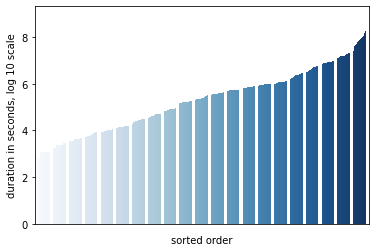

In [58]:
print('median total duration of events: ', pd.Timedelta(ranking_non_curtailed.total_duration.median(), unit='s')) 
print('arithmetic mean total duration of events: ', pd.Timedelta(ranking_non_curtailed.total_duration.mean(), unit='s'))
print('geometric mean total duration of events: ', pd.Timedelta(stats.gmean(ranking_non_curtailed.loc[:, 'total_duration'].values[ranking_non_curtailed.loc[:, 'total_duration'].values != 0]), unit='s'))
print('harmonic mean total duration of events: ', pd.Timedelta(stats.hmean(ranking_non_curtailed.loc[:, 'total_duration'].values[ranking_non_curtailed.loc[:, 'total_duration'].values != 0]), unit='s'))
print('geometric standard deviation total duration of events: ', pd.Timedelta(stats.gstd(ranking_non_curtailed.loc[:, 'total_duration'].values[ranking_non_curtailed.loc[:, 'total_duration'].values != 0]), unit='s'))
print('arithmetic standard deviation total duration of events: ', pd.Timedelta(stats.tstd(ranking_non_curtailed.loc[:, 'total_duration'].values), unit='s'))
print('Total duration of all 5112 events across all turbines: ', turbine_events[turbine_events.ErrorCode == 5112].Duration.sum())
print('Total duration of all comm faliure events across all turbines: ', turbine_events[turbine_events.ErrorCode == -1].Duration.sum())

plot_data = pd.DataFrame(data=ranking_non_curtailed.total_duration.sort_values())
plot_data = plot_data[plot_data.total_duration != 0]
plot_data = np.log10(plot_data)
plot_data['rank'] = range(len(plot_data))
display(plot_data)
ax = sns.barplot(x='rank', y='total_duration', data=plot_data, palette='Blues')
ax.set(xticklabels=[])
ax.set(ylabel="duration in seconds, log 10 scale")
ax.set(xlabel="sorted order")
ax.tick_params(bottom=False)

In [59]:
covered_ratio_zeroes.sort_values(by='difference', ascending=False)

,covered_dur,total_dur,difference
GDT059,133800,145200,11400
GDT015,553800,564000,10200
GDT062,52800,63000,10200
GDT058,285600,295200,9600
GDT026,54000,61800,7800
...,...,...,...
GDT075,46800,46800,0
GDT002,46800,46800,0
GDT039,46800,46800,0
GDT004,46800,46800,0


In [60]:
print('Total duration of 5112 events on turbine GDT058: ', turbine_events[(turbine_events.ErrorCode == 5112) & (turbine_events.Turbine == 'GDT058')].sort_values(by=['Duration'], ascending = False)['Duration'].sum())
print('Of which coincideing with curtailment: ', pd.Timedelta(covered_ratio_zeroes.loc['GDT058']['covered_dur'], unit='s'))

Total duration of 5112 events on turbine GDT058:  3 days 10:00:00
Of which coincideing with curtailment:  3 days 07:20:00


In [61]:
setpoint = SCADA_setpoint[SCADA_setpoint.Turbine == 'GDT059'].sort_values(by=['Timestamp']).set_index('Timestamp').loc['2021-02-19 09:20:00':'2021-02-19 11:00:00']
setpoint

,Value,Tag,Turbine
Timestamp,,,
2021-02-19 09:20:00,3600.0,WTUR11_WSpt_val,GDT059
2021-02-19 09:30:00,0.0,WTUR11_WSpt_val,GDT059
2021-02-19 09:40:00,0.0,WTUR11_WSpt_val,GDT059
2021-02-19 09:50:00,0.0,WTUR11_WSpt_val,GDT059
2021-02-19 10:00:00,0.0,WTUR11_WSpt_val,GDT059
2021-02-19 10:10:00,0.0,WTUR11_WSpt_val,GDT059
2021-02-19 10:50:00,3600.0,WTUR11_WSpt_val,GDT059
2021-02-19 11:00:00,3600.0,WTUR11_WSpt_val,GDT059


Computing the coverage durations, establishing a crude ranking and investigating event code 5112 has yielded following insights:

1. The **coverage ratio** method is a crude, yet **effective** tool to measure coincidence between curtailments and events. It works as followos: the sum of the fraction of the duration of each event in turbine_events that overlaps with a detected curtailment is divided by the total sum of event durations (with or without curtailment); a ratio of 1 means all events of this type happen to coincide with curtailment, a ratio of 0 means that events are always active when the turbine is at full rated power. A ranking is thus established by sorting the coverage ratios in descending order.
2. This metrics insights in coincidence between events and curtailment are interesting, but it also yields a **useful list** events that show a **high degree of separation from curtailment**, thus possibly serving as an **indicator for good turbine performance**.
3.   Treating missing setpoint data and 0 setpoint value as curtailment yields slight but noticeably different results than excluding those instances from the **definition of curtailment**.
4.   Upon investigating single instances of event 5112, it seems that **setpoint lowering kicks in only sometime after event 5112**. The setpoint will therefore be at rated power for a 10-minute interval while event 5112 triggers, and then be derated in the subsequent timestamps. Some information might be lost here, due to the rounding/flooring of the timestamps.
5. Event 5112 ranks **33th** out of 365 events (thus in the top 10%) in the duration ratio coinciding with curtailment metric for the curtailment definition treating missing data and 0 setpoint as potential curtailment. It only achieved rank **136** out of 365 when discarding missing data. This is due to 5112 highly correlating with missing data. When removing known causes for curtailment, event 5112 is to be found on spot **21** out of 365.
6. Event **durations are** very **heterogeneous**: 
  *   Some events happen on all turbines and last for long stretches of times, whereas occurances of other events are rare, short and far between. Thus, there is a big **discrepancy between the mean (arithmetic/geometric) and the median** of the sum of the total duration across all turbines of events per event-code.
  *   The **median duration is 2 days and 12:50 hours**, whereas the **mean duration is over 121 days**; the **geometric mean is just about 2 days**. The clearly follow a geometric ditribution.
  *   It can be argued, that **neither of the extremes are very interesting**: events with a high total duration, such as event '-1 comm failure', are very common and have likely been investigated already; events that are rare and short, on the other hand, do not impact production very much and should therefore be de-prioritized.
  * **The median is generally more robust to variance and outliers but more heavily influenced by skewedness**. To that end, a weighing function is applied. There are several options:
    * Trimming or [winsorising](https://encyclopediaofmath.org/wiki/Distance-weighted_mean) values would be a very crude method that would require setting arbitrary thresholds for data.
    * Applying a filter function used in digital filtering could instead allow for a gradual decrease in importance. Band-filters for instance.
    * Deriving weights from a [distance-weighed estimator](https://formulasearchengine.com/wiki/Distance-weighted_estimator) or a [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance) could also be an option.



In [62]:
def text_preprocessing(event_descriptions: pd.Series):
  from Stemmer.StemmerFactory import StemmerFactory
  from StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

  stemmer = StemmerFactory().create_stemmer()
  stopwords = StopWordRemoverFactory().get_stop_words()

  def text_preprocess(series, stemmer, stopwords):
      df = series.str.replace("\n\t",  " ")
      df = df.str.replace(r"[^a-zA-Z ]+", "")
      df = df.str.lower()
      df = df.apply(lambda x: ' '.join([stemmer.stem(item) for item in x.split() if item not in stopwords]))
      return df

  data['processed_text'] = text_preprocess(data['full_text'], stemmer, stopwords)


HM module SW ver Conflict I/O module SW ver Conflict GrdInv: 51 D3V curr-high GrdInv: 77 D4V curr-high GrdInv: 33 D1V curr-high GrdInv: 42 D2V curr-high GrdInv: 4 DC undervolts GenInv: 82 D4 volt-high FT1 Configuration error GenInv: 56 D3 volt-high GrdInv: 251 Delta 2 DIB +15v SecWindspeed < expect  Icing Stopped for SW update Availability - low wind GEN INV COM ERROR FT1 Sonic wind sensor error Local  scheduled service work Stop for powerdown Gridvolt<lower-limit4 Gridfreq<lower-limit1 Gridvolt<lower-limit3 GenInv: 111 CAN2 warnings Low lower-voltage exceeded INV MODBUS COM ERROR Inv Nac coolw pres sens err Charge main breaker cut out Manual idle stop Turbine in local operation GenInv: 47 D2 volt-high Gridvolt<lower-limit1


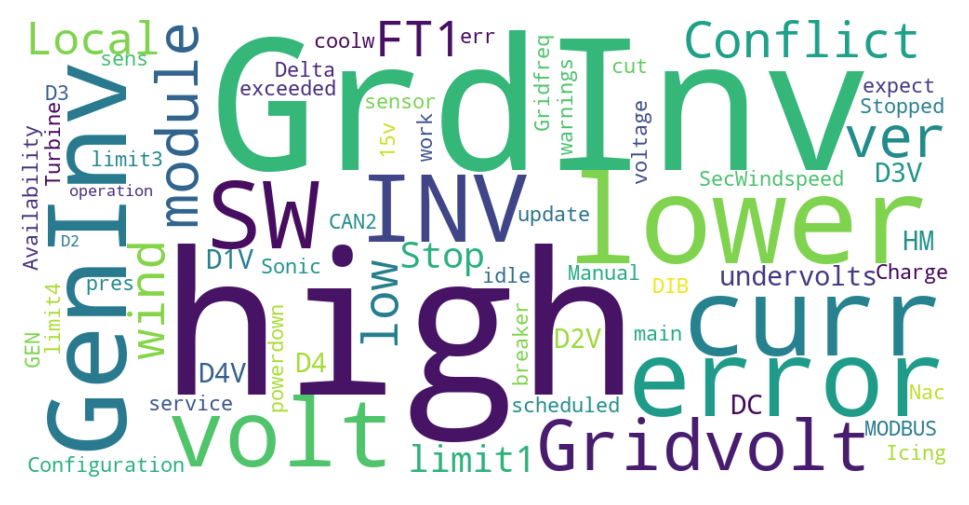

In [63]:
top20 = ranking_non_curtailed.head(30).index.values

top20desc = turbine_events[turbine_events.ErrorCode.isin(top20)][['ErrorCode', 'Text']].copy()
top20desc.ErrorCode = top20desc.ErrorCode.astype("category")
top20desc.ErrorCode.cat.set_categories(top20, inplace=True)
top20code = top20desc.sort_values(by='ErrorCode').ErrorCode.unique()
top20desc = top20desc.sort_values(by='ErrorCode').Text.unique()



text =  " ".join(desc for desc in top20desc)
text = text.replace('.', '').replace(' high', '-high').replace('lower ', 'lower-')
print(text)

wordcloud = WordCloud(max_words=100, background_color="white", height=500, width=1000).generate(text) #max_font_size=50

plt.rcParams['figure.dpi'] = 200
plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")
plt.show()

## Model functions: statistical and ML analyses

In [70]:
def daily_density_events_by_mutual_information(turbine_curtailments: pd.DataFrame, turbine_events: pd.DataFrame, verbose=True, repeats=10):
  """
  Compute mutual information scores for events based on daily density

  Args:
      turbine_curtailments: DataFrame containing flagged curtailment data for
      one turbine. All event flags required

      turbine_events: raw event DataFrame

      repeats: how often to perform mutual information estimation (not yet ported from old version)

  Returns:
      list of mutual information per event.
  """

  turbine_curtailments_list = turbine_curtailments.copy()


  codes = turbine_events['ErrorCode'].unique()
  codes = np.sort(codes)

  turbines = SCADA_setpoint["Turbine"].unique()
  turbines = np.sort(names)

  start = turbine_curtailments_list[0].index.min().floor(freq='24H')
  end = turbine_curtailments_list[0].index.max().floor(freq='24H')
  nrdays = (end-start).days

  repeater = np.zeros((len(codes), len(turbine_curtailments_list), repeats))

  indexnames = [start+timedelta(days=day)  for day in range(nrdays)]

  covered_ratio_data = pd.DataFrame(data=0, index=indexnames, columns=['End'])
  covered_ratio_data['End'] = covered_ratio_data.index+timedelta(minutes=(23*60+59))
  covered_ratio_data = [covered_ratio_data for i in range(80)]
  covered_ratio_data = expand_dummy_event_columns(covered_ratio_data, turbine_events)

  i = 0
  for turbine_curtailments in turbine_curtailments_list:

    single_turbine_events = turbine_events[turbine_events['Turbine']==names[i]].sort_values(by=['From']).copy()
    single_turbine_events = single_turbine_events.set_index('From')
    current = covered_ratio_data[i].copy()
    efficient_event_overlap_calculation(current, single_turbine_events)

    col_names = [str(code) + '_Coverage_Duration' for code in codes]

    current = current[col_names]

    turbine_curtailments= turbine_curtailments[~turbine_curtailments.Reported & 
                              ~turbine_curtailments.HWRT & 
                              ~turbine_curtailments.isTechnicianCurtailment].copy()
    turbine_curtailments['To'] = turbine_curtailments['End']
    turbine_curtailments['ErrorCode'] = 'Y'
    turbine_curtailments = turbine_curtailments[['To', 'ErrorCode']]

    currentcurt = pd.DataFrame(data=0, index=indexnames, columns=['End'])
    currentcurt['End'] = currentcurt.index+timedelta(minutes=(23*60+59))
    currentcurt['Y_Curtailment_Coverage'] = 0
    currentcurt['Y_Coverage_Duration'] = 0
    currentcurt['Y_Coverage_Ratio'] = 0
    efficient_event_overlap_calculation(currentcurt, turbine_curtailments)
    
    for repeat in range(repeats):

      repeater[:, i, repeat] = mutual_info_classif(current, currentcurt.Y_Coverage_Duration)


    i += 1
  avg_turbine_result = repeater.mean(axis=2)  
  result = avg_turbine_result.mean(axis=1)
  ranked_list = pd.DataFrame(data=0, index=codes, columns=['mutual information scores'])
  ranked_list['mutual information scores'] = result
  ranked_list['code'] = ranked_list.index
  ranked_list = ranked_list.sort_values(by=['mutual information scores'], ascending=False)
  ranked_list['rank'] = range(0, len(ranked_list))
  ranked_list = ranked_list.set_index('rank')
  return ranked_list
          

### Execution

In [77]:
ranked_list = daily_density_events_by_mutual_information(curtailments_with_zeroes[:1], turbine_events)

In [78]:
ranked_list

,mutual information scores,code
rank,,
0,0.101811,0
1,0.086135,1
2,0.065087,4
3,0.030584,3130
4,0.024000,3411
...,...,...
360,0.000355,13132
361,0.000347,15230
362,0.000320,15020


In [79]:
ranked_list[ranked_list['code'] == 5112]

,mutual information scores,code
rank,,
42,0.01599,5112


In [ ]:
def SCADA_to_timeseries(scada: pd.DataFrame, assume_normal_operation=True):
    """Create a timeseries DataFrame for the setpoint signal

    Args:
        scada: DataFrame containing the scada data in tag form.
        assume_normal_operation: if "Setpoint", NaN values will be set to 
        max power, else it is backfilled with the next non-NaN value.
        !!!Don't use for wind SCADA!!!

    Returns:
        DataFrame with setpoint arranged as time series
    """
    
    if assume_normal_operation:
      max_val = scada['Value'].max()
      scada = scada.pivot_table(index=['Timestamp'], columns=['Turbine']).fillna(max_val)
    else:
      scada = scada.pivot_table(index=['Timestamp'], columns=['Turbine']).fillna(method='bfill')
    
    return scada



def park_curtailment(SCADA_setpoint: pd.DataFrame, curtailment_reports: pd.DataFrame, turbine_events: pd.DataFrame, SCADA_windspeed: pd.DataFrame, difference_ratio=0.1) :
    # TODO: fix second half of function with updated turbine functions
    """Create a timeseries DataFrame containing all relevant information per 
    timestamp.

    Args:
        SCADA_setpoint: DataFrame containing the setpoint signal
        curtailment_reports: DataFrame containing the curtailment reports
        turbine_events: DataFrame containing turbine events
        SCADA_windspeed: DataFrame containing SCADA data about wind speeds
        difference_ratio: factor used to determine how much oscillation is 
        to be considered a new curtailment instance 

    Returns:
        DataFrame with aggregated park information about curtailment

    """

    #Set up data

    turbine_events = eventdf[['From_UTC', 'To_UTC', 'ErrorCode']]  
    SCADA_setpoint = df[['Timestamp', 'Turbine', 'Value', 'Tag']]
    curtailment_reports = dfcur[['From_Local', 'To_Local', 'Category']]

    maxval = df['Value'].max()
    
    setpoint_timeseries = setpoint_to_timeseries(SCADA_setpoint)

    #Add minum and mean values of setpoint

    park_curtailment = pd.DataFrame(index=thing.index)
    park_curtailment['setpoint_value_mean'] = thing.mean(axis=1)
    park_curtailment['setpoint_min'] = thing.min(axis=1)


    turbine_curtailments = []

    # Fix from here
    return

    park_curtailments = pd.DataFrame(columns=['timestamp', 'setpoint_value_mean', 'setpoint_min', 'reported_curtailment_active', 'affected_turbines', 'hwrt_likely', 'technician_likely', 'events_overlapping_curtailment', 'curtailemnt_coverage', 'event_coverage'])
    
    percent_done = 0 
    print("computing turbine curtailment")
    out = display(progress(0, 100), display_id=True)
    for turbine in turbinelist:
        prc = round(((percent_done/len(turbinelist))*100), 2)
        percent_done += 1
        out.update(progress(prc, 100))  
        turbine_curtailments.append(extract_curtailment_windows_from_setpoint(df[df['Turbine']==turbine], winddf[winddf['Turbine']==turbine], lag=lag, difference_ratio=difference_ratio))
    
    
    percent_done = 0 
    

    print("computing park curtailment")
    out = display(progress(0, 100), display_id=True)

    for timestamp in timeseries:
     
        #print("percent done: ", (round(percent_done/len(timeseries))*100), '%')
        prc = round(((percent_done/len(timeseries))*100), 2)
        print("\r percent done: ", prc, "%")
        percent_done += 1
        out.update(progress(prc, 100))  
        
        affected_turbines = []
        valsum = 0
        minval = maxval
        active = 'None'
        prevval = maxval
        
        overlap_codes = [] # collect turbine events for all turbines that have active curtailment
        ratio_curt = []
        ratio_evt = []            
        
        # If any turbine experiences technician curtailment or hwrt, add it as likely cause
        technician = False
        hwrt = False
        
        for turbine in turbinelist: # three nested for loops -> needs to be more efficient
            if len(df.loc[(df['Turbine'] == turbine) & (df['Timestamp'] == timestamp)]) == 0:
                val = prevval 
            else:
                val = df.loc[(df['Turbine'] == turbine) & (df['Timestamp'] == timestamp)]['Value'].item()
                prevval = val
            

            
            if val < maxval: # Only loop if setpoint derated
                affected_turbines.append(turbine)
                i, = np.where(turbinelist==turbine)
                curts = turbine_curtailments[i[0]]
                active_curt = None
                for curt in curts:
                    if during(curt.start, curt.end, timestamp):
                        active_curt = curt # curtailment active during this timestamp
                        if curt.text == "technician curtailment":
                            technician = True
                        if curt.text == "hwrt":
                            hwrt = True
                            
                if active_curt != None:
                    for event in eventdf[eventdf['Unit'] == turbine][['From_UTC', 'To_UTC', 'ErrorCode']].to_numpy() : # originally this loop was nested, but since curtailment, as defined previously, is not overlapping for a turbine, this can be sequential
                        overlapbool, delta, ratio_curtailment_covered, ratio_event_covered = active_curt.overlappingevent(event[0], event[1])
                        if overlapbool:
                            overlap_codes.append(event[2])
                            ratio_curt.append(round(ratio_curtailment_covered, 4)) # round to 4 digits for better visibility, more are not needed
                            ratio_evt.append(round(ratio_event_covered, 4))
            
                
        for curtailment in dfcur.iloc():
            if during(curtailment['From_Local'], curtailment['To_Local'], timestamp):
                active = curtailment['Category']
            
        s = pd.Series({'timestamp': timestamp, 'reported_curtailment_active' : active, 'affected_turbines': affected_turbines, 'hwrt_likely': hwrt, 'technician_likely': technician, 'events_overlapping_curtailment': overlap_codes, 'curtailemnt_coverage': ratio_curt, 'event_coverage': ratio_evt})
        park_curtailments = park_curtailments.append(s, ignore_index=True)
        
    return park_curtailments, turbine_curtailments, turbinelist
    